In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset , ValidUnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.99,
    "weight_decay" : 3e-5,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-DSV",
    "deep_super_vision" : True,
    "f_alpha":None
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]
out_counts = 7 if args["deep_super_vision"] else 1
loss_weights = [1/(2**i) for i in range(out_counts)]
loss_weights

[1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]

In [3]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [4]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
# f_alpha = (1-b)/(1-np.power(b,train_class_counts))
total = np.sum(train_class_counts)
f_alpha = np.log(total/np.array(train_class_counts))
f_alpha = (f_alpha / f_alpha.mean()).tolist()
f_alpha
args["f_alpha"] = f_alpha
f_alpha

[0.4192306623653949,
 0.7179025174767664,
 0.7172184312490237,
 0.7213506198648413,
 0.7718364322603585,
 0.6310175618202434,
 0.6310175618202434,
 0.7423200457906856,
 0.7659851796135413,
 0.8808365687040562,
 1.1472158488751967,
 1.4556618102528003,
 2.235638440011511,
 0.7578514761453713,
 1.1824730889495298,
 0.9906024194367986,
 0.7701509647332515,
 1.0385057663997224,
 1.238592452721393,
 1.3037247322439667,
 0.8402380298539683,
 1.2720560555504503,
 1.2438749107979519,
 1.3558847771047964,
 1.1742081741391486,
 0.9946054718189865]

In [5]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [6]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
    ]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None


In [7]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images,base_size=args["image_shape"][0],out_counts=out_counts)
valid_ds = ValidUnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [9]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     momentum=args["momentum"],
#     lr=args["lr"],
#     nesterov=True,
#     weight_decay=args["weight_decay"]
# )
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(
    args=args,
    recorder = recorder,
    model = model,
    optimizer = optimizer,
    loss_fn = loss_fn,
    train_loader = train_loader,
    valid_loader = valid_loader,
    loss_weights=loss_weights)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.9622, device='cuda:0')
train ==> epcoh (0)
total loss : 2.6139992618560792 - CE loss : 2.6237966322898867 - dice loss : -0.009797340328805148

train avg metrics for epoch 0 :
avg dice : 0.006535013663866536 - avg precision : 0.006277547325298656 - avg recall : 0.013053638449055143
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 0.918092742562294 - CE loss : 0.9234503865242004 - dice loss : -0.005357638048008084

valid avg metrics for epoch 0 :
avg dice : 0.013222725957057145 - avg precision : 0.015092571284621954 - avg recall : 0.01816610212899832
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7682, device='cuda:0')
--- Total Norm ---
tensor(0.6614, device='cuda:0')
train ==> epcoh (1)
total loss : 0.788187982738018 - CE loss : 0.8233216547966004 - dice loss : -0.03513368027284741

train avg metrics for epoch 1 :
avg dice : 0.02442165914308373 - avg precision : 0.044680095836520196 - avg recall : 0.0281218324641668
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 0.3527542263269424 - CE loss : 0.3712996423244476 - dice loss : -0.018545412831008433

valid avg metrics for epoch 1 :
avg dice : 0.019393742848595217 - avg precision : 0.06102534234523773 - avg recall : 0.027081551186274738
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3545, device='cuda:0')
train ==> epcoh (2)
total loss : 0.45923635601997376 - CE loss : 0.541241635978222 - dice loss : -0.08200528025627137

train avg metrics for epoch 2 :
avg dice : 0.046979218978960506 - avg precision : 0.08346494615077972 - avg recall : 0.06150371284005814
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 0.23943452164530754 - CE loss : 0.2848361097276211 - dice loss : -0.04540158789604902

valid avg metrics for epoch 2 :
avg dice : 0.07613287879193437 - avg precision : 0.10739072561264038 - avg recall : 0.07561811000108719
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5136, device='cuda:0')
--- Total Norm ---
tensor(0.6520, device='cuda:0')
train ==> epcoh (3)
total loss : 0.3265878476202488 - CE loss : 0.4689363521337509 - dice loss : -0.14234849758446216

train avg metrics for epoch 3 :
avg dice : 0.11599359013416784 - avg precision : 0.14402613759040833 - avg recall : 0.12190554524655454
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.1414475440979004 - CE loss : 0.23846601843833923 - dice loss : -0.09701847508549691

valid avg metrics for epoch 3 :
avg dice : 0.17383611470499297 - avg precision : 0.19759934842586518 - avg recall : 0.17808800235390662
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.20443860569503158 - CE loss : 0.42769475996494294 - dice loss : -0.22325615495443343

train avg metrics for epoch 4 :
avg dice : 0.17437420819463914 - avg precision : 0.18033905550837517 - avg recall : 0.18285426953108982
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.09717178568243981 - CE loss : 0.2307361125946045 - dice loss : -0.1335643269121647

valid avg metrics for epoch 4 :
avg dice : 0.19435099333562136 - avg precision : 0.19929243385791778 - avg recall : 0.2106240869872272
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6703, device='cuda:0')
train ==> epcoh (5)
total loss : 0.11951054421020672 - CE loss : 0.402626334130764 - dice loss : -0.2831157901883125

train avg metrics for epoch 5 :
avg dice : 0.20293797638543487 - avg precision : 0.20494871631264686 - avg recall : 0.21494069866661447
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.025983816385269164 - CE loss : 0.20841308757662774 - dice loss : -0.18242927119135857

valid avg metrics for epoch 5 :
avg dice : 0.23236471334508768 - avg precision : 0.24680306613445283 - avg recall : 0.23804289128165693
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.0453052890766412 - CE loss : 0.3804038643836975 - dice loss : -0.3350985749065876

train avg metrics for epoch 6 :
avg dice : 0.2248837099973725 - avg precision : 0.2224299919605255 - avg recall : 0.23664055991917848
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.015063130110502244 - CE loss : 0.2077699474990368 - dice loss : -0.19270681738853454

valid avg metrics for epoch 6 :
avg dice : 0.2384947571907114 - avg precision : 0.24469978883862495 - avg recall : 0.2554604237154126
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6052, device='cuda:0')
--- Total Norm ---
tensor(0.9693, device='cuda:0')
train ==> epcoh (7)
total loss : -0.0016623412491753697 - CE loss : 0.3636939461529255 - dice loss : -0.36535628512501717

train avg metrics for epoch 7 :
avg dice : 0.24365997160274547 - avg precision : 0.24088845126330852 - avg recall : 0.25751307779617494
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : -0.012122198566794395 - CE loss : 0.20040593296289444 - dice loss : -0.21252813152968883

valid avg metrics for epoch 7 :
avg dice : 0.25680986467115374 - avg precision : 0.2781006091833115 - avg recall : 0.2535036609816234
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6066, device='cuda:0')
--- Total Norm ---
tensor(0.7190, device='cuda:0')
train ==> epcoh (8)
total loss : -0.04607968299183995 - CE loss : 0.3513079613447189 - dice loss : -0.3973876392841339

train avg metrics for epoch 8 :
avg dice : 0.25746930609441604 - avg precision : 0.2531282545812428 - avg recall : 0.2732770660010283
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : -0.01209760531783104 - CE loss : 0.2070933014154434 - dice loss : -0.21919090673327446

valid avg metrics for epoch 8 :
avg dice : 0.2541267549063873 - avg precision : 0.28394357830286027 - avg recall : 0.24971491406671703
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5515, device='cuda:0')
--- Total Norm ---
tensor(0.7782, device='cuda:0')
train ==> epcoh (9)
total loss : -0.07576901060529054 - CE loss : 0.34456831380724906 - dice loss : -0.42033732652664185

train avg metrics for epoch 9 :
avg dice : 0.27087867624401496 - avg precision : 0.28038546577095985 - avg recall : 0.28412385446135885
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : -0.050895603746175765 - CE loss : 0.18550122901797295 - dice loss : -0.23639683276414872

valid avg metrics for epoch 9 :
avg dice : 0.28205563813481227 - avg precision : 0.29821944624185565 - avg recall : 0.29751563938800246
1 => dice : 0.7293903231620789 p : 0.6612805128097534 , r : 0.8131413459777832
2 => dice : 0.6624302268028259 p : 0.6866921782493591 , r : 0.6398242115974426
3 => dice : 0.6502208113670349 p : 0.598006546497345 , r : 0.7124254107475281
4 => dice : 0.5119242072105408 p : 0.5215401649475098 , r : 0.5026564598083496
5 => 

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7971, device='cuda:0')
train ==> epcoh (10)
total loss : -0.11484921965748071 - CE loss : 0.3294712296128273 - dice loss : -0.44432044833898543

train avg metrics for epoch 10 :
avg dice : 0.28812301591080397 - avg precision : 0.2994119641184807 - avg recall : 0.3017838011775166
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : -0.06173398867249489 - CE loss : 0.1798959668725729 - dice loss : -0.24162995517253877

valid avg metrics for epoch 10 :
avg dice : 0.28345569425294687 - avg precision : 0.3031244056671858 - avg recall : 0.29635397696984
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8668, device='cuda:0')
--- Total Norm ---
tensor(0.8820, device='cuda:0')
train ==> epcoh (11)
total loss : -0.10829314393922687 - CE loss : 0.33570659920573237 - dice loss : -0.4439997424185276

train avg metrics for epoch 11 :
avg dice : 0.2886687047830236 - avg precision : 0.299285601824522 - avg recall : 0.3000316447718069
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : -0.06944506466388703 - CE loss : 0.18028102815151215 - dice loss : -0.24972609281539918

valid avg metrics for epoch 11 :
avg dice : 0.29014336194876156 - avg precision : 0.29765241652727126 - avg recall : 0.3026107705011964
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5606, device='cuda:0')
train ==> epcoh (12)
total loss : -0.12357654995750636 - CE loss : 0.32760845854878423 - dice loss : -0.45118500649929044

train avg metrics for epoch 12 :
avg dice : 0.29493923030834734 - avg precision : 0.29926715284585953 - avg recall : 0.3093315072637051
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : -0.08038692772388459 - CE loss : 0.1766750618815422 - dice loss : -0.2570619896054268

valid avg metrics for epoch 12 :
avg dice : 0.3000595603140159 - avg precision : 0.33121960490942004 - avg recall : 0.30702414084225893
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6253, device='cuda:0')
--- Total Norm ---
tensor(0.7771, device='cuda:0')
--- Total Norm ---
tensor(0.9833, device='cuda:0')
train ==> epcoh (13)
total loss : -0.16246728609316052 - CE loss : 0.31438551440835 - dice loss : -0.4768528059124947

train avg metrics for epoch 13 :
avg dice : 0.315146292350075 - avg precision : 0.3178818320855498 - avg recall : 0.32898057249301926
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : -0.0855187050998211 - CE loss : 0.17574237808585166 - dice loss : -0.26126108318567276

valid avg metrics for epoch 13 :
avg dice : 0.3014097496870027 - avg precision : 0.31401306003332136 - avg recall : 0.307870402187109
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(2.9833, device='cuda:0')
--- Total Norm ---
tensor(0.6032, device='cuda:0')
train ==> epcoh (14)
total loss : -0.1707478679297492 - CE loss : 0.31388871937990187 - dice loss : -0.48463658064603804

train avg metrics for epoch 14 :
avg dice : 0.3174761239815884 - avg precision : 0.3148767724633217 - avg recall : 0.3317922837799415
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : -0.10243081152439118 - CE loss : 0.16867082379758358 - dice loss : -0.2711016349494457

valid avg metrics for epoch 14 :
avg dice : 0.32600482795695035 - avg precision : 0.3235579638928175 - avg recall : 0.3471308099559974
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6388, device='cuda:0')
train ==> epcoh (15)
total loss : -0.20197693830356 - CE loss : 0.30178953424096105 - dice loss : -0.5037664729356766

train avg metrics for epoch 15 :
avg dice : 0.3333879978120627 - avg precision : 0.3425158154964447 - avg recall : 0.34792426221072675
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : -0.09037216007709503 - CE loss : 0.1798677921295166 - dice loss : -0.2702399522066116

valid avg metrics for epoch 15 :
avg dice : 0.3201646808163981 - avg precision : 0.34784489929676055 - avg recall : 0.32778774132952093
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4870, device='cuda:0')
train ==> epcoh (16)
total loss : -0.1906581587251276 - CE loss : 0.31033857092261313 - dice loss : -0.5009967285394669

train avg metrics for epoch 16 :
avg dice : 0.3295692770871739 - avg precision : 0.3284896613890305 - avg recall : 0.3446234195521538
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : -0.09671778753399848 - CE loss : 0.1773878127336502 - dice loss : -0.2741056002676487

valid avg metrics for epoch 16 :
avg dice : 0.32426442788929366 - avg precision : 0.35176176749169824 - avg recall : 0.3226543251145631
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : -0.21858154503628613 - CE loss : 0.30072480022907255 - dice loss : -0.5193063434958458

train avg metrics for epoch 17 :
avg dice : 0.3408643121090046 - avg precision : 0.3492757788300514 - avg recall : 0.353382855579257
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : -0.1313855390995741 - CE loss : 0.16291542910039425 - dice loss : -0.2943009681999683

valid avg metrics for epoch 17 :
avg dice : 0.34784246083131687 - avg precision : 0.367991241440177 - avg recall : 0.3532061210251413
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : -0.2333525388594717 - CE loss : 0.2983068722486496 - dice loss : -0.5316594070196152

train avg metrics for epoch 18 :
avg dice : 0.3466704256674781 - avg precision : 0.3562212815042585 - avg recall : 0.36286019363706146
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : -0.14879679977893828 - CE loss : 0.15251256115734577 - dice loss : -0.301309360563755

valid avg metrics for epoch 18 :
avg dice : 0.35877661378369885 - avg precision : 0.3789878746494651 - avg recall : 0.3617068258521613
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7006, device='cuda:0')
train ==> epcoh (19)
total loss : -0.2604220414534211 - CE loss : 0.2863475532829762 - dice loss : -0.5467695960402489

train avg metrics for epoch 19 :
avg dice : 0.3641839454792422 - avg precision : 0.3625826620310545 - avg recall : 0.3828321471810341
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : -0.13393956795334816 - CE loss : 0.1641308393329382 - dice loss : -0.2980704076588154

valid avg metrics for epoch 19 :
avg dice : 0.35584729061067555 - avg precision : 0.3538751928508282 - avg recall : 0.37823930481652496
1 => dice : 0.7919431328773499 p : 0.7828536033630371 , r : 0.8012462854385376
2 => dice : 0.695315957069397 p : 0.7502548694610596 , r : 0.647874116897583
3 => dice : 0.7021887898445129 p : 0.6365537047386169 , r : 0.7829151153564453
4 => dice : 0.563545286655426 p : 0.6391299962997437 , r : 0.5039475560188293
5 => dice : 0.7363196015357971 p : 0.7454082369804382 , r : 0.72

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4785, device='cuda:0')
train ==> epcoh (20)
total loss : -0.26217217337340115 - CE loss : 0.29147270172834394 - dice loss : -0.5536448714137078

train avg metrics for epoch 20 :
avg dice : 0.3601071395379474 - avg precision : 0.35837491258978843 - avg recall : 0.3790495728049427
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : -0.14399005472660065 - CE loss : 0.15681862458586693 - dice loss : -0.3008086793124676

valid avg metrics for epoch 20 :
avg dice : 0.35780583448719594 - avg precision : 0.388318275436759 - avg recall : 0.3629232314415276
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : -0.28517309040296823 - CE loss : 0.28067574128508566 - dice loss : -0.5658488312363624

train avg metrics for epoch 21 :
avg dice : 0.37819974970109543 - avg precision : 0.379100067615509 - avg recall : 0.3934952720627189
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : -0.12263315916061401 - CE loss : 0.16322008222341539 - dice loss : -0.2858532413840294

valid avg metrics for epoch 21 :
avg dice : 0.34686785144743726 - avg precision : 0.3610361671447754 - avg recall : 0.34996027436107396
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5994, device='cuda:0')
train ==> epcoh (22)
total loss : -0.2661881180573255 - CE loss : 0.2867319226264954 - dice loss : -0.5529200410842896

train avg metrics for epoch 22 :
avg dice : 0.3690067825842631 - avg precision : 0.36790688678622246 - avg recall : 0.3877337113954127
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : -0.1397390052676201 - CE loss : 0.1609990905970335 - dice loss : -0.30073809549212455

valid avg metrics for epoch 22 :
avg dice : 0.35374785304082096 - avg precision : 0.35215937346220016 - avg recall : 0.3773513183416799
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5962, device='cuda:0')
--- Total Norm ---
tensor(0.4218, device='cuda:0')
train ==> epcoh (23)
total loss : -0.3150781558081508 - CE loss : 0.2744983349740505 - dice loss : -0.5895764937996865

train avg metrics for epoch 23 :
avg dice : 0.3890148372951877 - avg precision : 0.38146824911236765 - avg recall : 0.4075181396212429
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : -0.16141056567430495 - CE loss : 0.15493307113647461 - dice loss : -0.3163436368107796

valid avg metrics for epoch 23 :
avg dice : 0.3729922353570623 - avg precision : 0.3932262537628412 - avg recall : 0.3795127518230583
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : -0.3043659408437088 - CE loss : 0.2742027898132801 - dice loss : -0.578568723499775

train avg metrics for epoch 24 :
avg dice : 0.3864996332865191 - avg precision : 0.38044107109308245 - avg recall : 0.4063036358449608
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : -0.15422792881727218 - CE loss : 0.15865022577345372 - dice loss : -0.31287815421819687

valid avg metrics for epoch 24 :
avg dice : 0.37328849762688704 - avg precision : 0.402013935148716 - avg recall : 0.37782306208275257
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5193, device='cuda:0')
train ==> epcoh (25)
total loss : -0.3342169221490622 - CE loss : 0.26796043291687965 - dice loss : -0.6021773591637611

train avg metrics for epoch 25 :
avg dice : 0.4025783302638658 - avg precision : 0.3946425905823708 - avg recall : 0.4224965463206172
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : -0.1626942664384842 - CE loss : 0.15686037726700305 - dice loss : -0.3195546425879002

valid avg metrics for epoch 25 :
avg dice : 0.38047982480387516 - avg precision : 0.39375002548098564 - avg recall : 0.4009228022582829
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5988, device='cuda:0')
--- Total Norm ---
tensor(0.7407, device='cuda:0')
train ==> epcoh (26)
total loss : -0.32806077860295774 - CE loss : 0.2735400165617466 - dice loss : -0.6016007933020592

train avg metrics for epoch 26 :
avg dice : 0.4029530827704799 - avg precision : 0.39433347702026367 - avg recall : 0.42727063432335854
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : -0.13559800386428833 - CE loss : 0.17130002938210964 - dice loss : -0.30689803287386896

valid avg metrics for epoch 26 :
avg dice : 0.3581451794319911 - avg precision : 0.38491497933864594 - avg recall : 0.36137262180447577
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : -0.3434007486701012 - CE loss : 0.26648966446518896 - dice loss : -0.6098904100060463

train avg metrics for epoch 27 :
avg dice : 0.408625121489538 - avg precision : 0.39629186421632767 - avg recall : 0.4311869236826897
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : -0.13198177367448807 - CE loss : 0.16592813953757285 - dice loss : -0.29790991321206095

valid avg metrics for epoch 27 :
avg dice : 0.36062409989548627 - avg precision : 0.39325790137052535 - avg recall : 0.36276501409709455
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : -0.3420726144406945 - CE loss : 0.2633766156435013 - dice loss : -0.6054492339491844

train avg metrics for epoch 28 :
avg dice : 0.41036673903502346 - avg precision : 0.4024133840203285 - avg recall : 0.4314058566838503
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : -0.1613278515636921 - CE loss : 0.15688719153404235 - dice loss : -0.31821504458785055

valid avg metrics for epoch 28 :
avg dice : 0.37275780387233326 - avg precision : 0.3977218344807625 - avg recall : 0.375860295612365
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4213, device='cuda:0')
train ==> epcoh (29)
total loss : -0.35712019719183447 - CE loss : 0.2619399566948414 - dice loss : -0.6190601551532745

train avg metrics for epoch 29 :
avg dice : 0.41882567822970274 - avg precision : 0.41059993505477904 - avg recall : 0.4416875337064266
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : -0.15350986570119857 - CE loss : 0.16142093911767005 - dice loss : -0.3149308040738106

valid avg metrics for epoch 29 :
avg dice : 0.3758697732958136 - avg precision : 0.39479122940450906 - avg recall : 0.37917554402840326
1 => dice : 0.7643816471099854 p : 0.8376879692077637 , r : 0.7028729915618896
2 => dice : 0.7136545181274414 p : 0.7338984608650208 , r : 0.6944974660873413
3 => dice : 0.7019013166427612 p : 0.6998454332351685 , r : 0.7039692401885986
4 => dice : 0.5828291773796082 p : 0.575326144695282 , r : 0.590530514717102
5 => dice : 0.7416765093803406 p : 0.8048359155654907 , r :

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30)
total loss : -0.3472185967117548 - CE loss : 0.2678483086824417 - dice loss : -0.6150669053196907

train avg metrics for epoch 30 :
avg dice : 0.4179947097603214 - avg precision : 0.4118267273902893 - avg recall : 0.44095301419496535
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30)
total loss : -0.1664014220237732 - CE loss : 0.1573980875313282 - dice loss : -0.32379950806498525

valid avg metrics for epoch 30 :
avg dice : 0.3897139196471436 - avg precision : 0.4104377891123295 - avg recall : 0.3927487591281533
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7804, device='cuda:0')
--- Total Norm ---
tensor(0.8403, device='cuda:0')
train ==> epcoh (31)
total loss : -0.36377435352653265 - CE loss : 0.2594321809709072 - dice loss : -0.623206532895565

train avg metrics for epoch 31 :
avg dice : 0.42182034447826267 - avg precision : 0.4136906188726425 - avg recall : 0.4478232696652412
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31)
total loss : -0.17101668938994408 - CE loss : 0.15701448917388916 - dice loss : -0.32803117781877517

valid avg metrics for epoch 31 :
avg dice : 0.4000640061498744 - avg precision : 0.4215599328279495 - avg recall : 0.39658933840692046
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5232, device='cuda:0')
--- Total Norm ---
tensor(2.0191, device='cuda:0')
train ==> epcoh (32)
total loss : -0.36344619233161213 - CE loss : 0.2633738297224045 - dice loss : -0.6268200215697288

train avg metrics for epoch 32 :
avg dice : 0.42479738026894454 - avg precision : 0.41234980165958407 - avg recall : 0.44796648621559143
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32)
total loss : -0.12900311276316642 - CE loss : 0.17342706061899663 - dice loss : -0.30243017375469206

valid avg metrics for epoch 32 :
avg dice : 0.3606730771065814 - avg precision : 0.41126077964901925 - avg recall : 0.3502347310446203
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33)
total loss : -0.346752642467618 - CE loss : 0.26698240906000137 - dice loss : -0.6137350448966026

train avg metrics for epoch 33 :
avg dice : 0.41641997337378384 - avg precision : 0.4054691556096077 - avg recall : 0.43863516956567766
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : -0.17363946959376336 - CE loss : 0.15162263438105583 - dice loss : -0.32526210248470305

valid avg metrics for epoch 33 :
avg dice : 0.39627184969150775 - avg precision : 0.4213640260417014 - avg recall : 0.3925283079594374
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5135, device='cuda:0')
--- Total Norm ---
tensor(1.9276, device='cuda:0')
train ==> epcoh (34)
total loss : -0.3825164688937366 - CE loss : 0.25626681074500085 - dice loss : -0.6387832739949226

train avg metrics for epoch 34 :
avg dice : 0.4316704651717079 - avg precision : 0.4195799779891968 - avg recall : 0.4577856914699078
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : -0.17625962123274802 - CE loss : 0.15253327377140521 - dice loss : -0.32879289537668227

valid avg metrics for epoch 34 :
avg dice : 0.3976519213617904 - avg precision : 0.41325712859630587 - avg recall : 0.41350469149649144
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5915, device='cuda:0')
train ==> epcoh (35)
total loss : -0.3959947691112757 - CE loss : 0.24730182439088821 - dice loss : -0.6432965868711471

train avg metrics for epoch 35 :
avg dice : 0.4491387683156836 - avg precision : 0.43208699345588686 - avg recall : 0.47871105968952177
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35)
total loss : -0.17694206088781356 - CE loss : 0.15389185547828674 - dice loss : -0.3308339141309261

valid avg metrics for epoch 35 :
avg dice : 0.4002422374487979 - avg precision : 0.4235495412349701 - avg recall : 0.40039090789854526
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (36)
total loss : -0.4107712077349424 - CE loss : 0.24581315353512764 - dice loss : -0.6565843573212624

train avg metrics for epoch 36 :
avg dice : 0.4521341153983009 - avg precision : 0.4390156292915344 - avg recall : 0.47944883435964586
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (36)
total loss : -0.17040768191218375 - CE loss : 0.15644617192447186 - dice loss : -0.3268538534641266

valid avg metrics for epoch 36 :
avg dice : 0.4023892933503849 - avg precision : 0.4170166791975498 - avg recall : 0.4125227271951735
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4406, device='cuda:0')
train ==> epcoh (37)
total loss : -0.40261185795068744 - CE loss : 0.25127481639385224 - dice loss : -0.653886681497097

train avg metrics for epoch 37 :
avg dice : 0.4444182825092209 - avg precision : 0.4273257678747177 - avg recall : 0.4730060237646103
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (37)
total loss : -0.1737420417368412 - CE loss : 0.15310006216168404 - dice loss : -0.3268421031534672

valid avg metrics for epoch 37 :
avg dice : 0.4005270308257205 - avg precision : 0.4037200227379799 - avg recall : 0.42349336490035056
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8877, device='cuda:0')
--- Total Norm ---
tensor(0.7249, device='cuda:0')
--- Total Norm ---
tensor(0.4428, device='cuda:0')
--- Total Norm ---
tensor(0.4898, device='cuda:0')
train ==> epcoh (38)
total loss : -0.4216631741821766 - CE loss : 0.2451910960674286 - dice loss : -0.6668542683124542

train avg metrics for epoch 38 :
avg dice : 0.45479224979914545 - avg precision : 0.44151324689388277 - avg recall : 0.48386765509843827
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (38)
total loss : -0.18021318912506104 - CE loss : 0.15546903647482396 - dice loss : -0.33568222671747205

valid avg metrics for epoch 38 :
avg dice : 0.40448919624100754 - avg precision : 0.4194609859585762 - avg recall : 0.42080864161252973
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (39)
total loss : -0.4350280438363552 - CE loss : 0.24136823505163194 - dice loss : -0.6763962835073472

train avg metrics for epoch 39 :
avg dice : 0.4690305417779818 - avg precision : 0.44849846482276917 - avg recall : 0.5011074021458626
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (39)
total loss : -0.16329172477126122 - CE loss : 0.16366594806313514 - dice loss : -0.32695767357945443

valid avg metrics for epoch 39 :
avg dice : 0.39222509339462347 - avg precision : 0.4217277255654335 - avg recall : 0.39340732581913473
1 => dice : 0.7463294267654419 p : 0.7957029938697815 , r : 0.7027251720428467
2 => dice : 0.6868871450424194 p : 0.723634660243988 , r : 0.6536914706230164
3 => dice : 0.7357481718063354 p : 0.7506584525108337 , r : 0.7214187383651733
4 => dice : 0.6113237142562866 p : 0.6226376891136169 , r : 0.6004136204719543
5 => dice : 0.6929671168327332 p : 0.8637803196907043 , r : 0.5785570740699768
6 => dice : 0.6330547332763672

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7507, device='cuda:0')
--- Total Norm ---
tensor(0.6443, device='cuda:0')
--- Total Norm ---
tensor(0.4287, device='cuda:0')
train ==> epcoh (40)
total loss : -0.44480028212070466 - CE loss : 0.23868727907538415 - dice loss : -0.683487554192543

train avg metrics for epoch 40 :
avg dice : 0.46608310401476744 - avg precision : 0.44987711787223816 - avg recall : 0.4925894147157669
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (40)
total loss : -0.18591270670294763 - CE loss : 0.15591934956610204 - dice loss : -0.34183205515146253

valid avg metrics for epoch 40 :
avg dice : 0.41258897870789596 - avg precision : 0.4233881491422653 - avg recall : 0.42522627115249634
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (41)
total loss : -0.43068439051508906 - CE loss : 0.2468951389193535 - dice loss : -0.6775795239210128

train avg metrics for epoch 41 :
avg dice : 0.45767036557234647 - avg precision : 0.43889020800590517 - avg recall : 0.4882545006275177
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (41)
total loss : -0.16815554052591325 - CE loss : 0.16145404130220414 - dice loss : -0.3296095818281174

valid avg metrics for epoch 41 :
avg dice : 0.39706681847117226 - avg precision : 0.41656591843813656 - avg recall : 0.393763096164912
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6119, device='cuda:0')
train ==> epcoh (42)
total loss : -0.41677704706788066 - CE loss : 0.2486357381939888 - dice loss : -0.6654127785563468

train avg metrics for epoch 42 :
avg dice : 0.4544762766364944 - avg precision : 0.43773573338985444 - avg recall : 0.4793841975927353
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (42)
total loss : -0.18601332157850264 - CE loss : 0.15221533514559268 - dice loss : -0.33822865784168243

valid avg metrics for epoch 42 :
avg dice : 0.401775703951822 - avg precision : 0.4302956895530224 - avg recall : 0.4002103191614151
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5779, device='cuda:0')
train ==> epcoh (43)
total loss : -0.4373868754506111 - CE loss : 0.2442097370326519 - dice loss : -0.6815966099500657

train avg metrics for epoch 43 :
avg dice : 0.45976817905940004 - avg precision : 0.44150967240333555 - avg recall : 0.491292787194252
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (43)
total loss : -0.18243789076805114 - CE loss : 0.1567178688943386 - dice loss : -0.3391557581722736

valid avg metrics for epoch 43 :
avg dice : 0.41155511945496626 - avg precision : 0.4278469878435135 - avg recall : 0.4085029412806034
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (44)
total loss : -0.4419132198393345 - CE loss : 0.23813431993126868 - dice loss : -0.6800475418567657

train avg metrics for epoch 44 :
avg dice : 0.46915433645285487 - avg precision : 0.45064918100833895 - avg recall : 0.4989968371391296
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (44)
total loss : -0.18889753967523576 - CE loss : 0.15671165734529496 - dice loss : -0.3456091955304146

valid avg metrics for epoch 44 :
avg dice : 0.4173033125327093 - avg precision : 0.44289580907672643 - avg recall : 0.4102601192891598
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5810, device='cuda:0')
train ==> epcoh (45)
total loss : -0.4476615205407143 - CE loss : 0.23701298668980597 - dice loss : -0.6846744987368584

train avg metrics for epoch 45 :
avg dice : 0.4837050795558822 - avg precision : 0.46317957282066347 - avg recall : 0.5134152948856354
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (45)
total loss : -0.18711191713809966 - CE loss : 0.1554463990032673 - dice loss : -0.3425583153963089

valid avg metrics for epoch 45 :
avg dice : 0.41105906657885144 - avg precision : 0.4345859740674496 - avg recall : 0.41680616434663537
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (46)
total loss : -0.4583653147518635 - CE loss : 0.2377211232483387 - dice loss : -0.6960864359140396

train avg metrics for epoch 46 :
avg dice : 0.4761189568046463 - avg precision : 0.45416959285736086 - avg recall : 0.5080167919397354
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (46)
total loss : -0.16818686574697495 - CE loss : 0.16691713333129882 - dice loss : -0.33510399907827376

valid avg metrics for epoch 46 :
avg dice : 0.4008386120201213 - avg precision : 0.4396123938262463 - avg recall : 0.39157947853207586
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (47)
total loss : -0.4468309015035629 - CE loss : 0.24130721598863603 - dice loss : -0.6881381168961525

train avg metrics for epoch 47 :
avg dice : 0.4722144740823639 - avg precision : 0.4520860105752945 - avg recall : 0.5051342397928238
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (47)
total loss : -0.19311389476060867 - CE loss : 0.15012760907411576 - dice loss : -0.3432415030896664

valid avg metrics for epoch 47 :
avg dice : 0.4179933488370044 - avg precision : 0.43656864047050475 - avg recall : 0.4166080924868584
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5845, device='cuda:0')
train ==> epcoh (48)
total loss : -0.4512864975631237 - CE loss : 0.23783778935670852 - dice loss : -0.6891242945194245

train avg metrics for epoch 48 :
avg dice : 0.48252238333262326 - avg precision : 0.4619292253255844 - avg recall : 0.5146466833353043
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (48)
total loss : -0.18645021244883536 - CE loss : 0.15362243503332138 - dice loss : -0.3400726467370987

valid avg metrics for epoch 48 :
avg dice : 0.4028318016232116 - avg precision : 0.40890284374356267 - avg recall : 0.41556464076042177
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (49)
total loss : -0.4736289328336716 - CE loss : 0.23431041195988656 - dice loss : -0.7079393509030342

train avg metrics for epoch 49 :
avg dice : 0.48692176759280087 - avg precision : 0.4657942163944244 - avg recall : 0.5201133126020432
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (49)
total loss : -0.18487413823604584 - CE loss : 0.15973880402743817 - dice loss : -0.34461294263601305

valid avg metrics for epoch 49 :
avg dice : 0.4144218026102645 - avg precision : 0.4529690308123827 - avg recall : 0.39939453184604645
1 => dice : 0.7664636969566345 p : 0.8120620250701904 , r : 0.7257139682769775
2 => dice : 0.6854857206344604 p : 0.7686040997505188 , r : 0.6185901761054993
3 => dice : 0.7172238826751709 p : 0.7064986824989319 , r : 0.728279709815979
4 => dice : 0.5935593247413635 p : 0.5843815207481384 , r : 0.6030300855636597
5 => dice : 0.7651098966598511 p : 0.7826640605926514 , r : 0.7483259439468384
6 => dice : 0.6653490662574768 

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (50)
total loss : -0.489636038094759 - CE loss : 0.22872568935155868 - dice loss : -0.7183617305755615

train avg metrics for epoch 50 :
avg dice : 0.4952963918451202 - avg precision : 0.47329098284244536 - avg recall : 0.5279728543758392
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (50)
total loss : -0.18460699766874314 - CE loss : 0.15825661607086658 - dice loss : -0.34286361560225487

valid avg metrics for epoch 50 :
avg dice : 0.4134455919266803 - avg precision : 0.41981576189398767 - avg recall : 0.4299708479642868
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5452, device='cuda:0')
--- Total Norm ---
tensor(0.3989, device='cuda:0')
train ==> epcoh (51)
total loss : -0.49521329514682294 - CE loss : 0.22619808480143547 - dice loss : -0.7214113789796829

train avg metrics for epoch 51 :
avg dice : 0.4997845834497345 - avg precision : 0.47743632555007937 - avg recall : 0.5333690196275711
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (51)
total loss : -0.18514101803302765 - CE loss : 0.16034562028944493 - dice loss : -0.34548663944005964

valid avg metrics for epoch 51 :
avg dice : 0.42110011398802827 - avg precision : 0.43279459729790687 - avg recall : 0.44044517785310744
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9687, device='cuda:0')
--- Total Norm ---
tensor(0.7091, device='cuda:0')
train ==> epcoh (52)
total loss : -0.46741908576339486 - CE loss : 0.23677956759929658 - dice loss : -0.7041986504197121

train avg metrics for epoch 52 :
avg dice : 0.49162969231642606 - avg precision : 0.4688698160648346 - avg recall : 0.525017112493515
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (52)
total loss : -0.20203497484326363 - CE loss : 0.14904647134244442 - dice loss : -0.35108144506812095

valid avg metrics for epoch 52 :
avg dice : 0.4258089679480655 - avg precision : 0.43759158335626125 - avg recall : 0.423411857932806
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5399, device='cuda:0')
train ==> epcoh (53)
total loss : -0.48943359166383743 - CE loss : 0.22972963124513626 - dice loss : -0.7191632142663003

train avg metrics for epoch 53 :
avg dice : 0.49696819305456996 - avg precision : 0.47588018655776976 - avg recall : 0.5276575595140457
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (53)
total loss : -0.19230517968535424 - CE loss : 0.1559948783367872 - dice loss : -0.34830005690455434

valid avg metrics for epoch 53 :
avg dice : 0.4075342117251022 - avg precision : 0.43831786945462226 - avg recall : 0.41583468645811084
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5334, device='cuda:0')
--- Total Norm ---
tensor(0.5166, device='cuda:0')
--- Total Norm ---
tensor(0.5776, device='cuda:0')
train ==> epcoh (54)
total loss : -0.5061329978704453 - CE loss : 0.227116968780756 - dice loss : -0.7332499706745148

train avg metrics for epoch 54 :
avg dice : 0.5007271593812829 - avg precision : 0.4760079890489578 - avg recall : 0.5384351634979248
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (54)
total loss : -0.1748530723154545 - CE loss : 0.16368925273418428 - dice loss : -0.33854232355952263

valid avg metrics for epoch 54 :
avg dice : 0.40523210570459567 - avg precision : 0.4094160554604605 - avg recall : 0.4148747151705902
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4337, device='cuda:0')
--- Total Norm ---
tensor(0.5982, device='cuda:0')
train ==> epcoh (55)
total loss : -0.5181086019799114 - CE loss : 0.22180742233991624 - dice loss : -0.7399160149693489

train avg metrics for epoch 55 :
avg dice : 0.5156926482919582 - avg precision : 0.49197820127010344 - avg recall : 0.5502287662029266
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (55)
total loss : -0.2016048863530159 - CE loss : 0.1557888027280569 - dice loss : -0.3573936901986599

valid avg metrics for epoch 55 :
avg dice : 0.42839382126937936 - avg precision : 0.45148661226034165 - avg recall : 0.4219052143394947
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5738, device='cuda:0')
train ==> epcoh (56)
total loss : -0.4937401205301285 - CE loss : 0.231791216135025 - dice loss : -0.725531339943409

train avg metrics for epoch 56 :
avg dice : 0.5032423484329113 - avg precision : 0.47853462159633636 - avg recall : 0.539293292760849
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (56)
total loss : -0.16857890114188195 - CE loss : 0.1649217288941145 - dice loss : -0.3335006296634674

valid avg metrics for epoch 56 :
avg dice : 0.40233028098951407 - avg precision : 0.4250468960404396 - avg recall : 0.4158637506514788
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6457, device='cuda:0')
--- Total Norm ---
tensor(0.4916, device='cuda:0')
train ==> epcoh (57)
total loss : -0.5043980397284031 - CE loss : 0.22755865395069122 - dice loss : -0.7319566982984543

train avg metrics for epoch 57 :
avg dice : 0.506197313070668 - avg precision : 0.48387736320495606 - avg recall : 0.5368027937412262
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (57)
total loss : -0.19155511260032654 - CE loss : 0.15955453291535376 - dice loss : -0.35110964477062223

valid avg metrics for epoch 57 :
avg dice : 0.4217660719157321 - avg precision : 0.4530831925570965 - avg recall : 0.41984242882579564
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (58)
total loss : -0.5169560560584068 - CE loss : 0.22277765229344368 - dice loss : -0.739733703136444

train avg metrics for epoch 58 :
avg dice : 0.5161417520049938 - avg precision : 0.491935555934906 - avg recall : 0.5515195763111115
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (58)
total loss : -0.192421867698431 - CE loss : 0.15909553058445453 - dice loss : -0.3515173986554146

valid avg metrics for epoch 58 :
avg dice : 0.4176730653644664 - avg precision : 0.43829401016235353 - avg recall : 0.4139568558335304
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6324, device='cuda:0')
--- Total Norm ---
tensor(0.7319, device='cuda:0')
--- Total Norm ---
tensor(0.5106, device='cuda:0')
train ==> epcoh (59)
total loss : -0.5200234964489937 - CE loss : 0.2217387506365776 - dice loss : -0.7417622545361519

train avg metrics for epoch 59 :
avg dice : 0.5213167178634537 - avg precision : 0.49749558329582216 - avg recall : 0.5535857009887696
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (59)
total loss : -0.1916756011545658 - CE loss : 0.1605338916182518 - dice loss : -0.3522094927728176

valid avg metrics for epoch 59 :
avg dice : 0.42130163595090936 - avg precision : 0.4405070035159588 - avg recall : 0.4163117849826813
1 => dice : 0.7977924942970276 p : 0.8318374156951904 , r : 0.7664247155189514
2 => dice : 0.7131485342979431 p : 0.7545433044433594 , r : 0.6760594248771667
3 => dice : 0.7183395028114319 p : 0.7521774172782898 , r : 0.6874150633811951
4 => dice : 0.6554595232009888 p : 0.63

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6227, device='cuda:0')
--- Total Norm ---
tensor(0.9620, device='cuda:0')
--- Total Norm ---
tensor(0.6080, device='cuda:0')
train ==> epcoh (60)
total loss : -0.5404693269729615 - CE loss : 0.2163396418094635 - dice loss : -0.7568089753389359

train avg metrics for epoch 60 :
avg dice : 0.5261323261264694 - avg precision : 0.5003272843360901 - avg recall : 0.5631618487834931
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (60)
total loss : -0.19171896800398827 - CE loss : 0.15957348085939885 - dice loss : -0.3512924499809742

valid avg metrics for epoch 60 :
avg dice : 0.41896484777341914 - avg precision : 0.43494070440530774 - avg recall : 0.424413615912199
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (61)
total loss : -0.5281686472892761 - CE loss : 0.21819201201200486 - dice loss : -0.7463606542348862

train avg metrics for epoch 61 :
avg dice : 0.5231874179843795 - avg precision : 0.496846067905426 - avg recall : 0.5609730327129364
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (61)
total loss : -0.1847221828997135 - CE loss : 0.1627531759440899 - dice loss : -0.34747535958886144

valid avg metrics for epoch 61 :
avg dice : 0.41622833609591553 - avg precision : 0.44384001329541206 - avg recall : 0.40575610160827635
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6136, device='cuda:0')
--- Total Norm ---
tensor(0.5302, device='cuda:0')
train ==> epcoh (62)
total loss : -0.5479847413301467 - CE loss : 0.21610273465514182 - dice loss : -0.7640874737501144

train avg metrics for epoch 62 :
avg dice : 0.5284070527557266 - avg precision : 0.5044512879848481 - avg recall : 0.5620936071872711
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (62)
total loss : -0.19108291938900948 - CE loss : 0.16053108051419257 - dice loss : -0.35161399841308594

valid avg metrics for epoch 62 :
avg dice : 0.42311602503071855 - avg precision : 0.4496015387773514 - avg recall : 0.4309860706329346
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6496, device='cuda:0')
train ==> epcoh (63)
total loss : -0.5444367380440235 - CE loss : 0.2144478391110897 - dice loss : -0.7588845753669738

train avg metrics for epoch 63 :
avg dice : 0.5370902252200973 - avg precision : 0.5109813022613525 - avg recall : 0.5752332001924515
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (63)
total loss : -0.19960250705480576 - CE loss : 0.1568074721843004 - dice loss : -0.35640997886657716

valid avg metrics for epoch 63 :
avg dice : 0.42166885644208024 - avg precision : 0.4436010508239269 - avg recall : 0.42834785774350165
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (64)
total loss : -0.5500560915470123 - CE loss : 0.21350836977362633 - dice loss : -0.7635644626617432

train avg metrics for epoch 64 :
avg dice : 0.5375004088882339 - avg precision : 0.5124217081069946 - avg recall : 0.5723846125602722
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (64)
total loss : -0.19486195370554923 - CE loss : 0.1583362568169832 - dice loss : -0.3531982108950615

valid avg metrics for epoch 64 :
avg dice : 0.42577704191218446 - avg precision : 0.432018980383873 - avg recall : 0.43860846519470215
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5855, device='cuda:0')
train ==> epcoh (65)
total loss : -0.5378169795870781 - CE loss : 0.21893817394971848 - dice loss : -0.7567551562190056

train avg metrics for epoch 65 :
avg dice : 0.5288971614841355 - avg precision : 0.5017502862215042 - avg recall : 0.568283063173294
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (65)
total loss : -0.1746063731610775 - CE loss : 0.16887137144804001 - dice loss : -0.3434777453541756

valid avg metrics for epoch 65 :
avg dice : 0.4071204036475284 - avg precision : 0.4165791556239128 - avg recall : 0.4287585201859474
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5957, device='cuda:0')
train ==> epcoh (66)
total loss : -0.5505509606003761 - CE loss : 0.2146736888587475 - dice loss : -0.7652246612310409

train avg metrics for epoch 66 :
avg dice : 0.5378567588333023 - avg precision : 0.5114416444301605 - avg recall : 0.574135617017746
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (66)
total loss : -0.20092148929834366 - CE loss : 0.16137518025934697 - dice loss : -0.36229666993021964

valid avg metrics for epoch 66 :
avg dice : 0.43407486379157134 - avg precision : 0.44773017093539236 - avg recall : 0.44718245297670367
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (67)
total loss : -0.5735049341619015 - CE loss : 0.20995711654424667 - dice loss : -0.783462051153183

train avg metrics for epoch 67 :
avg dice : 0.5498821234706771 - avg precision : 0.5227666175365449 - avg recall : 0.5885096776485443
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (67)
total loss : -0.20582036152482033 - CE loss : 0.15593537837266921 - dice loss : -0.3617557384073734

valid avg metrics for epoch 67 :
avg dice : 0.4277045837045772 - avg precision : 0.4329955378174782 - avg recall : 0.43999498754739763
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5087, device='cuda:0')
train ==> epcoh (68)
total loss : -0.5744954133033753 - CE loss : 0.2114150443673134 - dice loss : -0.7859104582667351

train avg metrics for epoch 68 :
avg dice : 0.5449864006046188 - avg precision : 0.5178928136825561 - avg recall : 0.5857722461223602
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (68)
total loss : -0.17866756543517112 - CE loss : 0.16544101797044278 - dice loss : -0.3441085837781429

valid avg metrics for epoch 68 :
avg dice : 0.4131460165978534 - avg precision : 0.4354782569408417 - avg recall : 0.4264990217983723
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.6062, device='cuda:0')
train ==> epcoh (69)
total loss : -0.5776376092433929 - CE loss : 0.21097430914640428 - dice loss : -0.7886119109392166

train avg metrics for epoch 69 :
avg dice : 0.5482891070846451 - avg precision : 0.5225412762165069 - avg recall : 0.5854110991954804
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (69)
total loss : -0.1754182532429695 - CE loss : 0.1714595478028059 - dice loss : -0.34687780067324636

valid avg metrics for epoch 69 :
avg dice : 0.4133803513647182 - avg precision : 0.43607844538986684 - avg recall : 0.4092167815566063
1 => dice : 0.7893788814544678 p : 0.8166024684906006 , r : 0.7639119029045105
2 => dice : 0.7141944766044617 p : 0.7368645668029785 , r : 0.6928775906562805
3 => dice : 0.7202604413032532 p : 0.6773830652236938 , r : 0.7689327597618103
4 => dice : 0.6426644325256348 p : 0.681047260761261 , r : 0.60837721824646
5 => dice : 0.7692670226097107 p : 0.8091566562652588 , r : 0.73

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7031, device='cuda:0')
--- Total Norm ---
tensor(0.7190, device='cuda:0')
--- Total Norm ---
tensor(0.6498, device='cuda:0')
train ==> epcoh (70)
total loss : -0.5581306962668896 - CE loss : 0.21781351089477538 - dice loss : -0.7759442055225372

train avg metrics for epoch 70 :
avg dice : 0.5433703649047744 - avg precision : 0.5163066470623017 - avg recall : 0.5817962729930878
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (70)
total loss : -0.20280409529805182 - CE loss : 0.1546439167112112 - dice loss : -0.3574480123817921

valid avg metrics for epoch 70 :
avg dice : 0.43095462515960764 - avg precision : 0.43836008742451665 - avg recall : 0.4347595727443695
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (71)
total loss : -0.5781947189569473 - CE loss : 0.205699166059494 - dice loss : -0.7838938841223717

train avg metrics for epoch 71 :
avg dice : 0.5542829537395371 - avg precision : 0.528697338104248 - avg recall : 0.5897013366222381
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (71)
total loss : -0.17582419663667678 - CE loss : 0.17345323637127877 - dice loss : -0.34927743300795555

valid avg metrics for epoch 71 :
avg dice : 0.40824366875003404 - avg precision : 0.4225799560546875 - avg recall : 0.4143545588850975
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5079, device='cuda:0')
--- Total Norm ---
tensor(0.5259, device='cuda:0')
train ==> epcoh (72)
total loss : -0.5886233514547348 - CE loss : 0.203851955011487 - dice loss : -0.7924753105640412

train avg metrics for epoch 72 :
avg dice : 0.5630152964595687 - avg precision : 0.5362331748008728 - avg recall : 0.6017027425765992
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (72)
total loss : -0.20317400321364404 - CE loss : 0.15998503267765046 - dice loss : -0.3631590366363525

valid avg metrics for epoch 72 :
avg dice : 0.43356875643144677 - avg precision : 0.4613052825629711 - avg recall : 0.42728912621736526
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (73)
total loss : -0.5817369675636291 - CE loss : 0.20659673988819122 - dice loss : -0.7883337038755417

train avg metrics for epoch 73 :
avg dice : 0.5681012415889626 - avg precision : 0.5403004455566406 - avg recall : 0.6063770055770874
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (73)
total loss : -0.1919265516102314 - CE loss : 0.16386335603892804 - dice loss : -0.35578990876674654

valid avg metrics for epoch 73 :
avg dice : 0.4177402102948291 - avg precision : 0.4240531903505325 - avg recall : 0.43336664587259294
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (74)
total loss : -0.5874297615885734 - CE loss : 0.20630904980003834 - dice loss : -0.7937388014793396

train avg metrics for epoch 74 :
avg dice : 0.5645498657230273 - avg precision : 0.5397194635868072 - avg recall : 0.5966521155834198
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (74)
total loss : -0.20368761494755744 - CE loss : 0.15936689972877502 - dice loss : -0.36305451318621634

valid avg metrics for epoch 74 :
avg dice : 0.42871867269288133 - avg precision : 0.42844004690647125 - avg recall : 0.45355606377124785
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5313, device='cuda:0')
train ==> epcoh (75)
total loss : -0.5828159925341606 - CE loss : 0.20688459023833275 - dice loss : -0.789700584411621

train avg metrics for epoch 75 :
avg dice : 0.5611856639388931 - avg precision : 0.5344466078281402 - avg recall : 0.5991701602935791
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (75)
total loss : -0.20308153480291366 - CE loss : 0.15835228003561497 - dice loss : -0.3614338167011738

valid avg metrics for epoch 75 :
avg dice : 0.4288920509816272 - avg precision : 0.44204026728868484 - avg recall : 0.4420328705012798
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7157, device='cuda:0')
train ==> epcoh (76)
total loss : -0.5897068591415882 - CE loss : 0.20521302036941053 - dice loss : -0.794919883608818

train avg metrics for epoch 76 :
avg dice : 0.5651351678375137 - avg precision : 0.5376936852931976 - avg recall : 0.6013113570213318
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (76)
total loss : -0.1997506819665432 - CE loss : 0.16326917745172978 - dice loss : -0.363019859790802

valid avg metrics for epoch 76 :
avg dice : 0.43383579328666755 - avg precision : 0.4532679954916239 - avg recall : 0.4303630197048187
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (77)
total loss : -0.6085259240865707 - CE loss : 0.19696796655654908 - dice loss : -0.8054938900470734

train avg metrics for epoch 77 :
avg dice : 0.5895489466194053 - avg precision : 0.5623964047431946 - avg recall : 0.6257729065418244
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (77)
total loss : -0.20675341114401818 - CE loss : 0.16182190030813218 - dice loss : -0.3685753121972084

valid avg metrics for epoch 77 :
avg dice : 0.43681860774766035 - avg precision : 0.44743522092700005 - avg recall : 0.43984744131565096
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5439, device='cuda:0')
train ==> epcoh (78)
total loss : -0.619744648784399 - CE loss : 0.1977458480745554 - dice loss : -0.817490496635437

train avg metrics for epoch 78 :
avg dice : 0.5824562048915751 - avg precision : 0.5542972338199615 - avg recall : 0.6208719301223755
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (78)
total loss : -0.19297630563378335 - CE loss : 0.16669895090162754 - dice loss : -0.3596752561628819

valid avg metrics for epoch 78 :
avg dice : 0.4257183560730083 - avg precision : 0.45390324652194974 - avg recall : 0.42625220596790314
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (79)
total loss : -0.6086132851243019 - CE loss : 0.20253537327051163 - dice loss : -0.8111486613750458

train avg metrics for epoch 79 :
avg dice : 0.5718800210956466 - avg precision : 0.5452738559246063 - avg recall : 0.6071381902694702
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (79)
total loss : -0.1844101630151272 - CE loss : 0.16852471902966498 - dice loss : -0.35293488278985025

valid avg metrics for epoch 79 :
avg dice : 0.41854420751343796 - avg precision : 0.4400619746744633 - avg recall : 0.41502680256962776
1 => dice : 0.8183727264404297 p : 0.7938883304595947 , r : 0.8444154262542725
2 => dice : 0.728934109210968 p : 0.7300334572792053 , r : 0.7278380990028381
3 => dice : 0.7222797274589539 p : 0.6720050573348999 , r : 0.7806851267814636
4 => dice : 0.6427610516548157 p : 0.6470022797584534 , r : 0.63857501745224
5 => dice : 0.7285007238388062 p : 0.8868108987808228 , r : 0.6181507110595703
6 => dice : 0.6658769845962524 p :

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.7743, device='cuda:0')
train ==> epcoh (80)
total loss : -0.6107740473747253 - CE loss : 0.19910812005400658 - dice loss : -0.8098821648955346

train avg metrics for epoch 80 :
avg dice : 0.5788803899291886 - avg precision : 0.5489339327812195 - avg recall : 0.619752436876297
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (80)
total loss : -0.18337583914399147 - CE loss : 0.1712125450372696 - dice loss : -0.35458838269114495

valid avg metrics for epoch 80 :
avg dice : 0.4214491607994897 - avg precision : 0.4597951930761337 - avg recall : 0.40276535898447036
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5528, device='cuda:0')
train ==> epcoh (81)
total loss : -0.6303107033669949 - CE loss : 0.19637987054884434 - dice loss : -0.8266905725002289

train avg metrics for epoch 81 :
avg dice : 0.5836740684512985 - avg precision : 0.5578587687015534 - avg recall : 0.6194395411014557
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (81)
total loss : -0.184394720941782 - CE loss : 0.16965831816196442 - dice loss : -0.3540530376136303

valid avg metrics for epoch 81 :
avg dice : 0.42057187885056563 - avg precision : 0.4295862556993961 - avg recall : 0.44240038633346557
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4851, device='cuda:0')
--- Total Norm ---
tensor(0.5353, device='cuda:0')
train ==> epcoh (82)
total loss : -0.6364018827676773 - CE loss : 0.19727319180965425 - dice loss : -0.8336750769615173

train avg metrics for epoch 82 :
avg dice : 0.5921038782600295 - avg precision : 0.5640477871894837 - avg recall : 0.6308900916576385
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (82)
total loss : -0.18388690054416656 - CE loss : 0.1735442142933607 - dice loss : -0.3574311152100563

valid avg metrics for epoch 82 :
avg dice : 0.42140639219443626 - avg precision : 0.43943531431257726 - avg recall : 0.4170503384247422
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (83)
total loss : -0.6320860120654106 - CE loss : 0.1963983790576458 - dice loss : -0.8284843850135803

train avg metrics for epoch 83 :
avg dice : 0.591822358370198 - avg precision : 0.564175330400467 - avg recall : 0.6292516386508942
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (83)
total loss : -0.17950038164854049 - CE loss : 0.17593993991613388 - dice loss : -0.3554403230547905

valid avg metrics for epoch 83 :
avg dice : 0.4208464580775363 - avg precision : 0.4594336350262165 - avg recall : 0.41402853906154635
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (84)
total loss : -0.6196664050221443 - CE loss : 0.19759012073278426 - dice loss : -0.8172565224766731

train avg metrics for epoch 84 :
avg dice : 0.5926754784587753 - avg precision : 0.564311192035675 - avg recall : 0.6310700345039367
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (84)
total loss : -0.17016415521502495 - CE loss : 0.1804253153502941 - dice loss : -0.35058946907520294

valid avg metrics for epoch 84 :
avg dice : 0.4155360932649238 - avg precision : 0.47726191103458404 - avg recall : 0.38901573956012725
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (85)
total loss : -0.6225754776597023 - CE loss : 0.20077794581651687 - dice loss : -0.8233534175157547

train avg metrics for epoch 85 :
avg dice : 0.5858466041091812 - avg precision : 0.5588014650344849 - avg recall : 0.6230431759357452
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (85)
total loss : -0.18249428570270537 - CE loss : 0.17290593460202217 - dice loss : -0.35540022104978564

valid avg metrics for epoch 85 :
avg dice : 0.42825588963237904 - avg precision : 0.45730041483417155 - avg recall : 0.41148441725410523
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5831, device='cuda:0')
train ==> epcoh (86)
total loss : -0.6075265873968602 - CE loss : 0.2016263211518526 - dice loss : -0.8091528993844986

train avg metrics for epoch 86 :
avg dice : 0.5815954136852157 - avg precision : 0.5532414066791534 - avg recall : 0.620586724281311
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (86)
total loss : -0.1774483233690262 - CE loss : 0.17262377515435218 - dice loss : -0.3500720992684364

valid avg metrics for epoch 86 :
avg dice : 0.41515237048278875 - avg precision : 0.4447137998789549 - avg recall : 0.40212402675300835
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5906, device='cuda:0')
train ==> epcoh (87)
total loss : -0.6713825699687004 - CE loss : 0.18945533342659474 - dice loss : -0.8608378952741623

train avg metrics for epoch 87 :
avg dice : 0.6087817835811511 - avg precision : 0.5805973541736603 - avg recall : 0.646580685377121
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (87)
total loss : -0.18588464632630347 - CE loss : 0.16982438378036022 - dice loss : -0.3557090312242508

valid avg metrics for epoch 87 :
avg dice : 0.42587855948145814 - avg precision : 0.4509235083125532 - avg recall : 0.4202513960748911
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4927, device='cuda:0')
--- Total Norm ---
tensor(0.4656, device='cuda:0')
train ==> epcoh (88)
total loss : -0.6665717002749443 - CE loss : 0.18751794062554836 - dice loss : -0.8540896445512771

train avg metrics for epoch 88 :
avg dice : 0.6106557714942811 - avg precision : 0.5847180378437042 - avg recall : 0.6443768835067749
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (88)
total loss : -0.1872842639684677 - CE loss : 0.17343126758933067 - dice loss : -0.3607155315577984

valid avg metrics for epoch 88 :
avg dice : 0.43174522936354703 - avg precision : 0.44971672132611273 - avg recall : 0.43170171439647675
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (89)
total loss : -0.6649577715992927 - CE loss : 0.18849837377667428 - dice loss : -0.8534561532735825

train avg metrics for epoch 89 :
avg dice : 0.6129659616950884 - avg precision : 0.5850498521327973 - avg recall : 0.6483655512332916
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (89)
total loss : -0.16876203417778016 - CE loss : 0.18345450460910798 - dice loss : -0.3522165395319462

valid avg metrics for epoch 89 :
avg dice : 0.4197175158561332 - avg precision : 0.45756149366497995 - avg recall : 0.39891995303332806
1 => dice : 0.7728837132453918 p : 0.8067849278450012 , r : 0.7417166233062744
2 => dice : 0.7026819586753845 p : 0.7730077505111694 , r : 0.6440851092338562
3 => dice : 0.7238641381263733 p : 0.685754656791687 , r : 0.7664585709571838
4 => dice : 0.6244267225265503 p : 0.6467405557632446 , r : 0.603601336479187
5 => dice : 0.759157121181488 p : 0.7747145295143127 , r : 0.7442122101783752
6 => dice : 0.6813259720802307 p :

  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.8782, device='cuda:0')
--- Total Norm ---
tensor(0.6063, device='cuda:0')
train ==> epcoh (90)
total loss : -0.6839906322956085 - CE loss : 0.184859157577157 - dice loss : -0.8688497892022133

train avg metrics for epoch 90 :
avg dice : 0.6220839321617019 - avg precision : 0.5940249717235565 - avg recall : 0.659089560508728
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (90)
total loss : -0.1429045468568802 - CE loss : 0.19873297289013864 - dice loss : -0.34163751900196077

valid avg metrics for epoch 90 :
avg dice : 0.40285644635568685 - avg precision : 0.43301940351724627 - avg recall : 0.40611326090991495
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (91)
total loss : -0.6478138983249664 - CE loss : 0.19400906801223755 - dice loss : -0.8418229675292969

train avg metrics for epoch 91 :
avg dice : 0.6053250730041397 - avg precision : 0.5752827107906342 - avg recall : 0.6465569937229156
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (91)
total loss : -0.17668138369917868 - CE loss : 0.1744195520877838 - dice loss : -0.35110093727707864

valid avg metrics for epoch 91 :
avg dice : 0.416854601744668 - avg precision : 0.43128697663545607 - avg recall : 0.4129293308034539
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.9639, device='cuda:0')
train ==> epcoh (92)
total loss : -0.6681417608261109 - CE loss : 0.18571464754641057 - dice loss : -0.8538564038276673

train avg metrics for epoch 92 :
avg dice : 0.6195003926757682 - avg precision : 0.5906340730190277 - avg recall : 0.6588933098316193
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (92)
total loss : -0.18335005417466163 - CE loss : 0.17351533398032187 - dice loss : -0.35686538740992546

valid avg metrics for epoch 92 :
avg dice : 0.4177116021514995 - avg precision : 0.43746709018945695 - avg recall : 0.4217462700605392
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.3640, device='cuda:0')
train ==> epcoh (93)
total loss : -0.6779999020695686 - CE loss : 0.18277360923588276 - dice loss : -0.8607735174894333

train avg metrics for epoch 93 :
avg dice : 0.6312299358848464 - avg precision : 0.6042958343029022 - avg recall : 0.6658492290973663
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (93)
total loss : -0.17844199314713477 - CE loss : 0.17772304229438304 - dice loss : -0.3561650350689888

valid avg metrics for epoch 93 :
avg dice : 0.42202906757603714 - avg precision : 0.4590365736186504 - avg recall : 0.41852760449051857
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(1.2238, device='cuda:0')
--- Total Norm ---
tensor(0.6522, device='cuda:0')
train ==> epcoh (94)
total loss : -0.6193100149929524 - CE loss : 0.20350062802433969 - dice loss : -0.8228106617927551

train avg metrics for epoch 94 :
avg dice : 0.593766528368367 - avg precision : 0.5660300469398498 - avg recall : 0.6319470942020416
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (94)
total loss : -0.14941881150007247 - CE loss : 0.19236824661493301 - dice loss : -0.3417870581150055

valid avg metrics for epoch 94 :
avg dice : 0.4057540945709808 - avg precision : 0.4131240687519312 - avg recall : 0.4172087597846985
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5336, device='cuda:0')
train ==> epcoh (95)
total loss : -0.6653614073991776 - CE loss : 0.18800473779439927 - dice loss : -0.8533661437034606

train avg metrics for epoch 95 :
avg dice : 0.6181622421745192 - avg precision : 0.5885533654689789 - avg recall : 0.6569788467884063
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (95)
total loss : -0.1901823453605175 - CE loss : 0.1716755371540785 - dice loss : -0.361857882887125

valid avg metrics for epoch 95 :
avg dice : 0.4263533627987964 - avg precision : 0.44795245185494426 - avg recall : 0.4244383683800697
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (96)
total loss : -0.6790148168802261 - CE loss : 0.1829259083420038 - dice loss : -0.861940724849701

train avg metrics for epoch 96 :
avg dice : 0.6289912307266128 - avg precision : 0.6021479439735412 - avg recall : 0.6631133139133454
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (96)
total loss : -0.17964405491948127 - CE loss : 0.18013206124305725 - dice loss : -0.3597761169075966

valid avg metrics for epoch 96 :
avg dice : 0.418922176957236 - avg precision : 0.4492277647554874 - avg recall : 0.4259204232692719
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (97)
total loss : -0.7003533861041069 - CE loss : 0.1806626458466053 - dice loss : -0.8810160219669342

train avg metrics for epoch 97 :
avg dice : 0.6416643643382918 - avg precision : 0.6127094936370849 - avg recall : 0.6805987942218781
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (97)
total loss : -0.17676425725221634 - CE loss : 0.18006669580936432 - dice loss : -0.35683095157146455

valid avg metrics for epoch 97 :
avg dice : 0.4183878523112399 - avg precision : 0.44890099778771403 - avg recall : 0.4031574798375368
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.5845, device='cuda:0')
train ==> epcoh (98)
total loss : -0.6935814020037651 - CE loss : 0.18271379075944424 - dice loss : -0.8762951844930649

train avg metrics for epoch 98 :
avg dice : 0.636760649681462 - avg precision : 0.6097393953800201 - avg recall : 0.6711516761779786
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (98)
total loss : -0.17069124430418015 - CE loss : 0.18647840581834316 - dice loss : -0.35716965049505234

valid avg metrics for epoch 98 :
avg dice : 0.4227362163365943 - avg precision : 0.4483999566733837 - avg recall : 0.4347715713083744
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

--- Total Norm ---
tensor(0.4721, device='cuda:0')
train ==> epcoh (99)
total loss : -0.7085109892487526 - CE loss : 0.17858529716730118 - dice loss : -0.8870962768793106

train avg metrics for epoch 99 :
avg dice : 0.6472438657287484 - avg precision : 0.6165878093242645 - avg recall : 0.6880457997322083
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (99)
total loss : -0.1804101325571537 - CE loss : 0.17967875264585018 - dice loss : -0.3600888840854168

valid avg metrics for epoch 99 :
avg dice : 0.43007665008317064 - avg precision : 0.45348805814981463 - avg recall : 0.43232909560203553
1 => dice : 0.8082592487335205 p : 0.7993608713150024 , r : 0.8173578977584839
2 => dice : 0.7177063822746277 p : 0.7516438961029053 , r : 0.6867010593414307
3 => dice : 0.7432962656021118 p : 0.7153847217559814 , r : 0.7734742164611816
4 => dice : 0.6449784636497498 p : 0.5900649428367615 , r : 0.7111616134643555
5 => dice : 0.7839834690093994 p : 0.791005551815033 , r : 

In [11]:
torch.save(model.state_dict(), "model.pth")

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 2896.62it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

processing ./temp_script.py


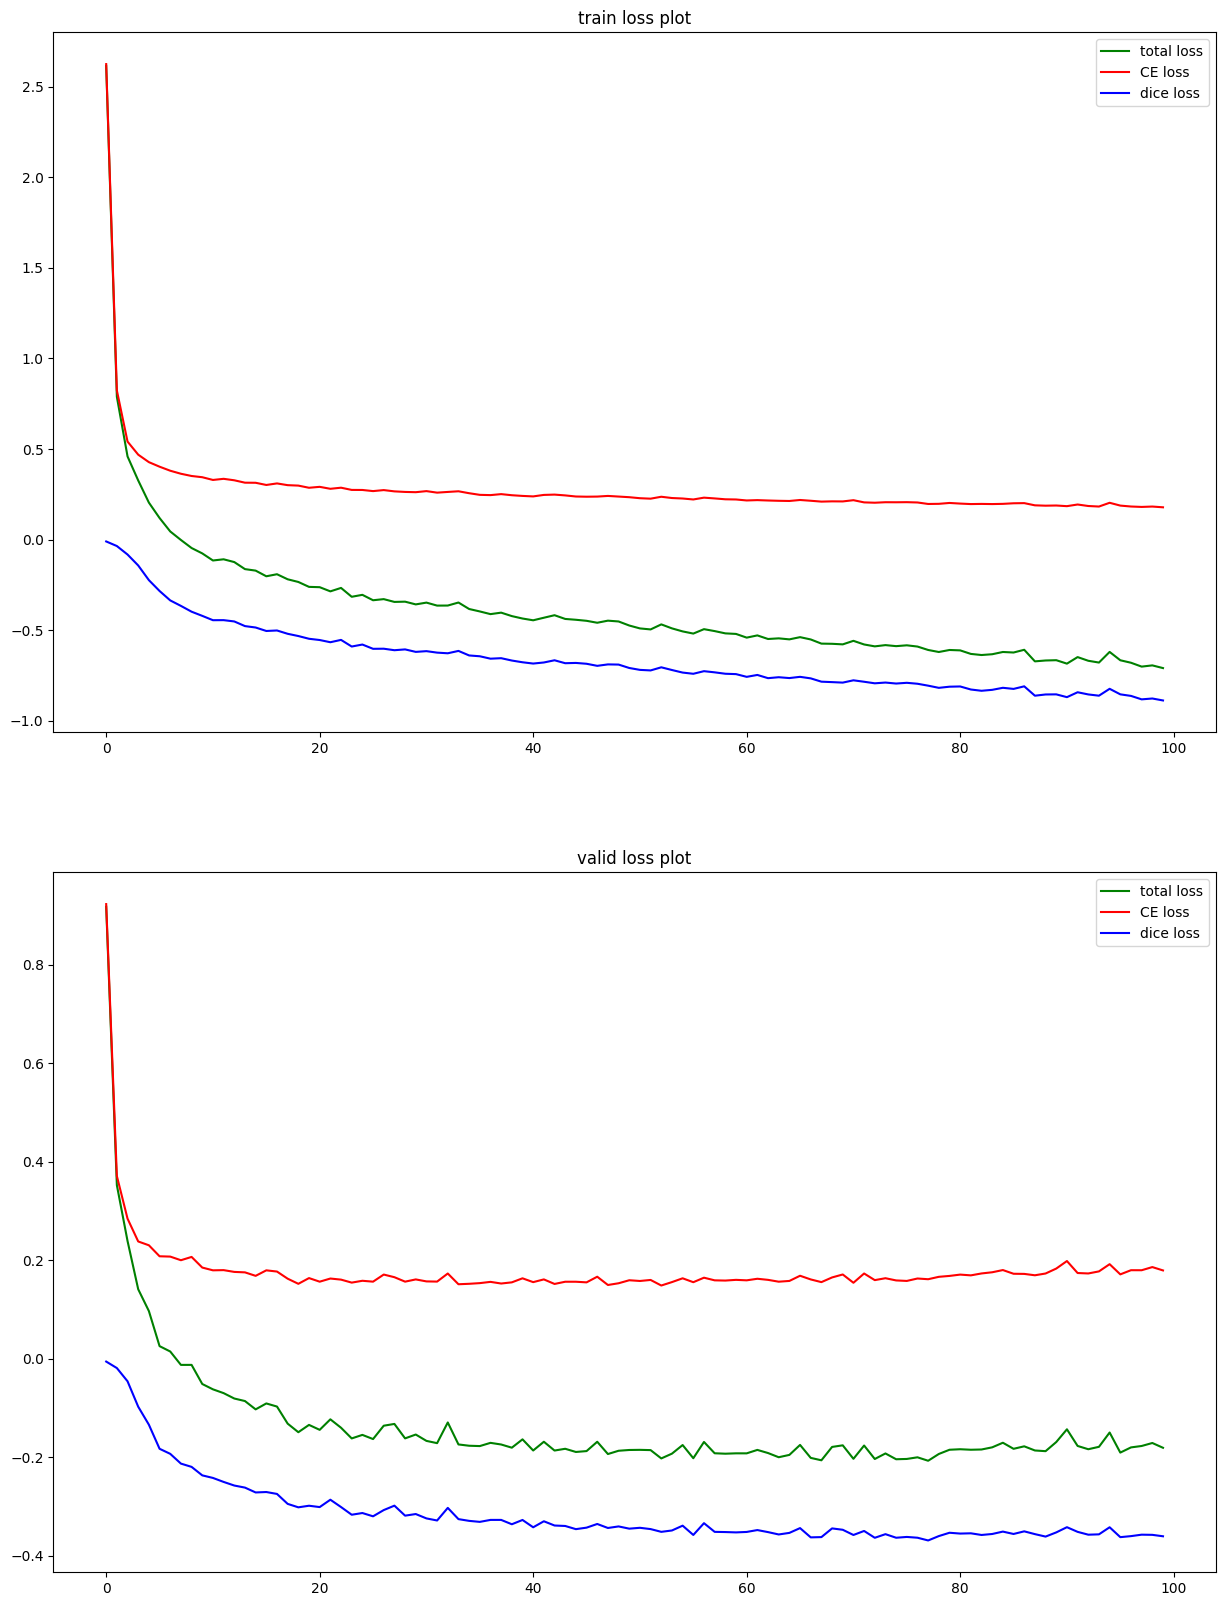

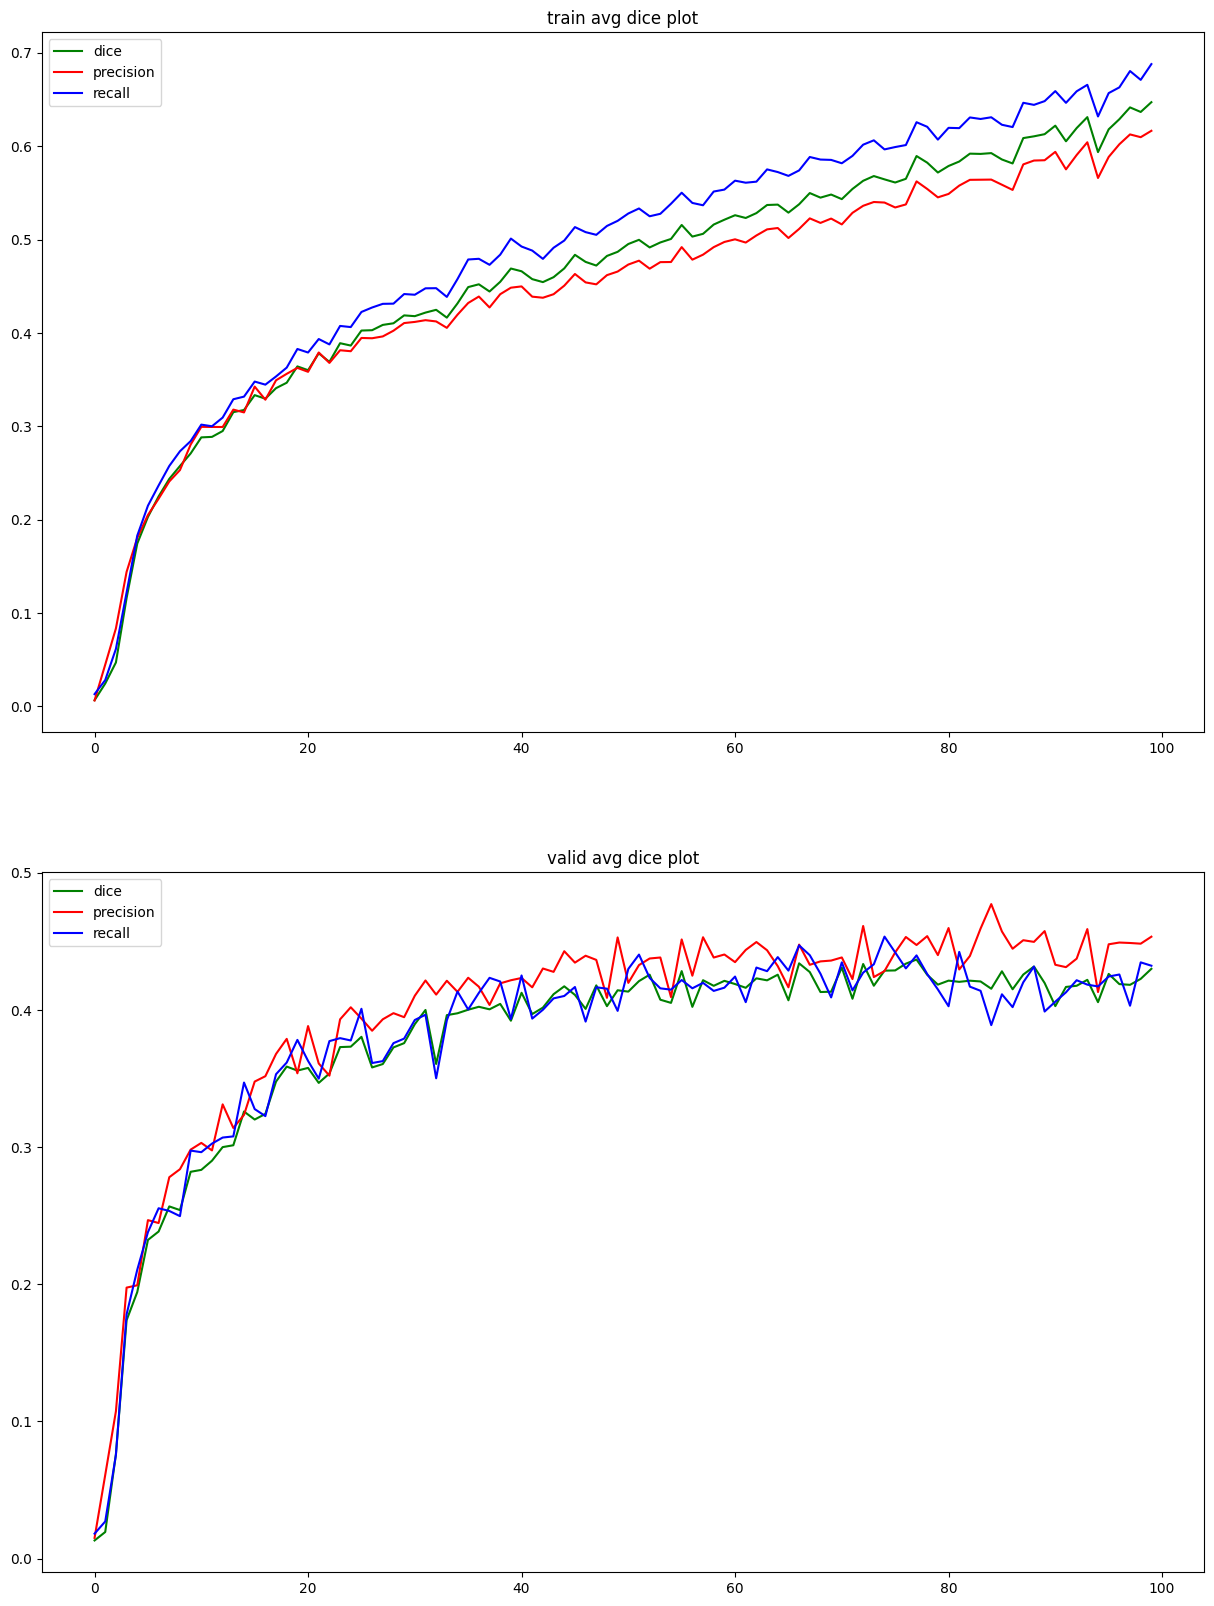

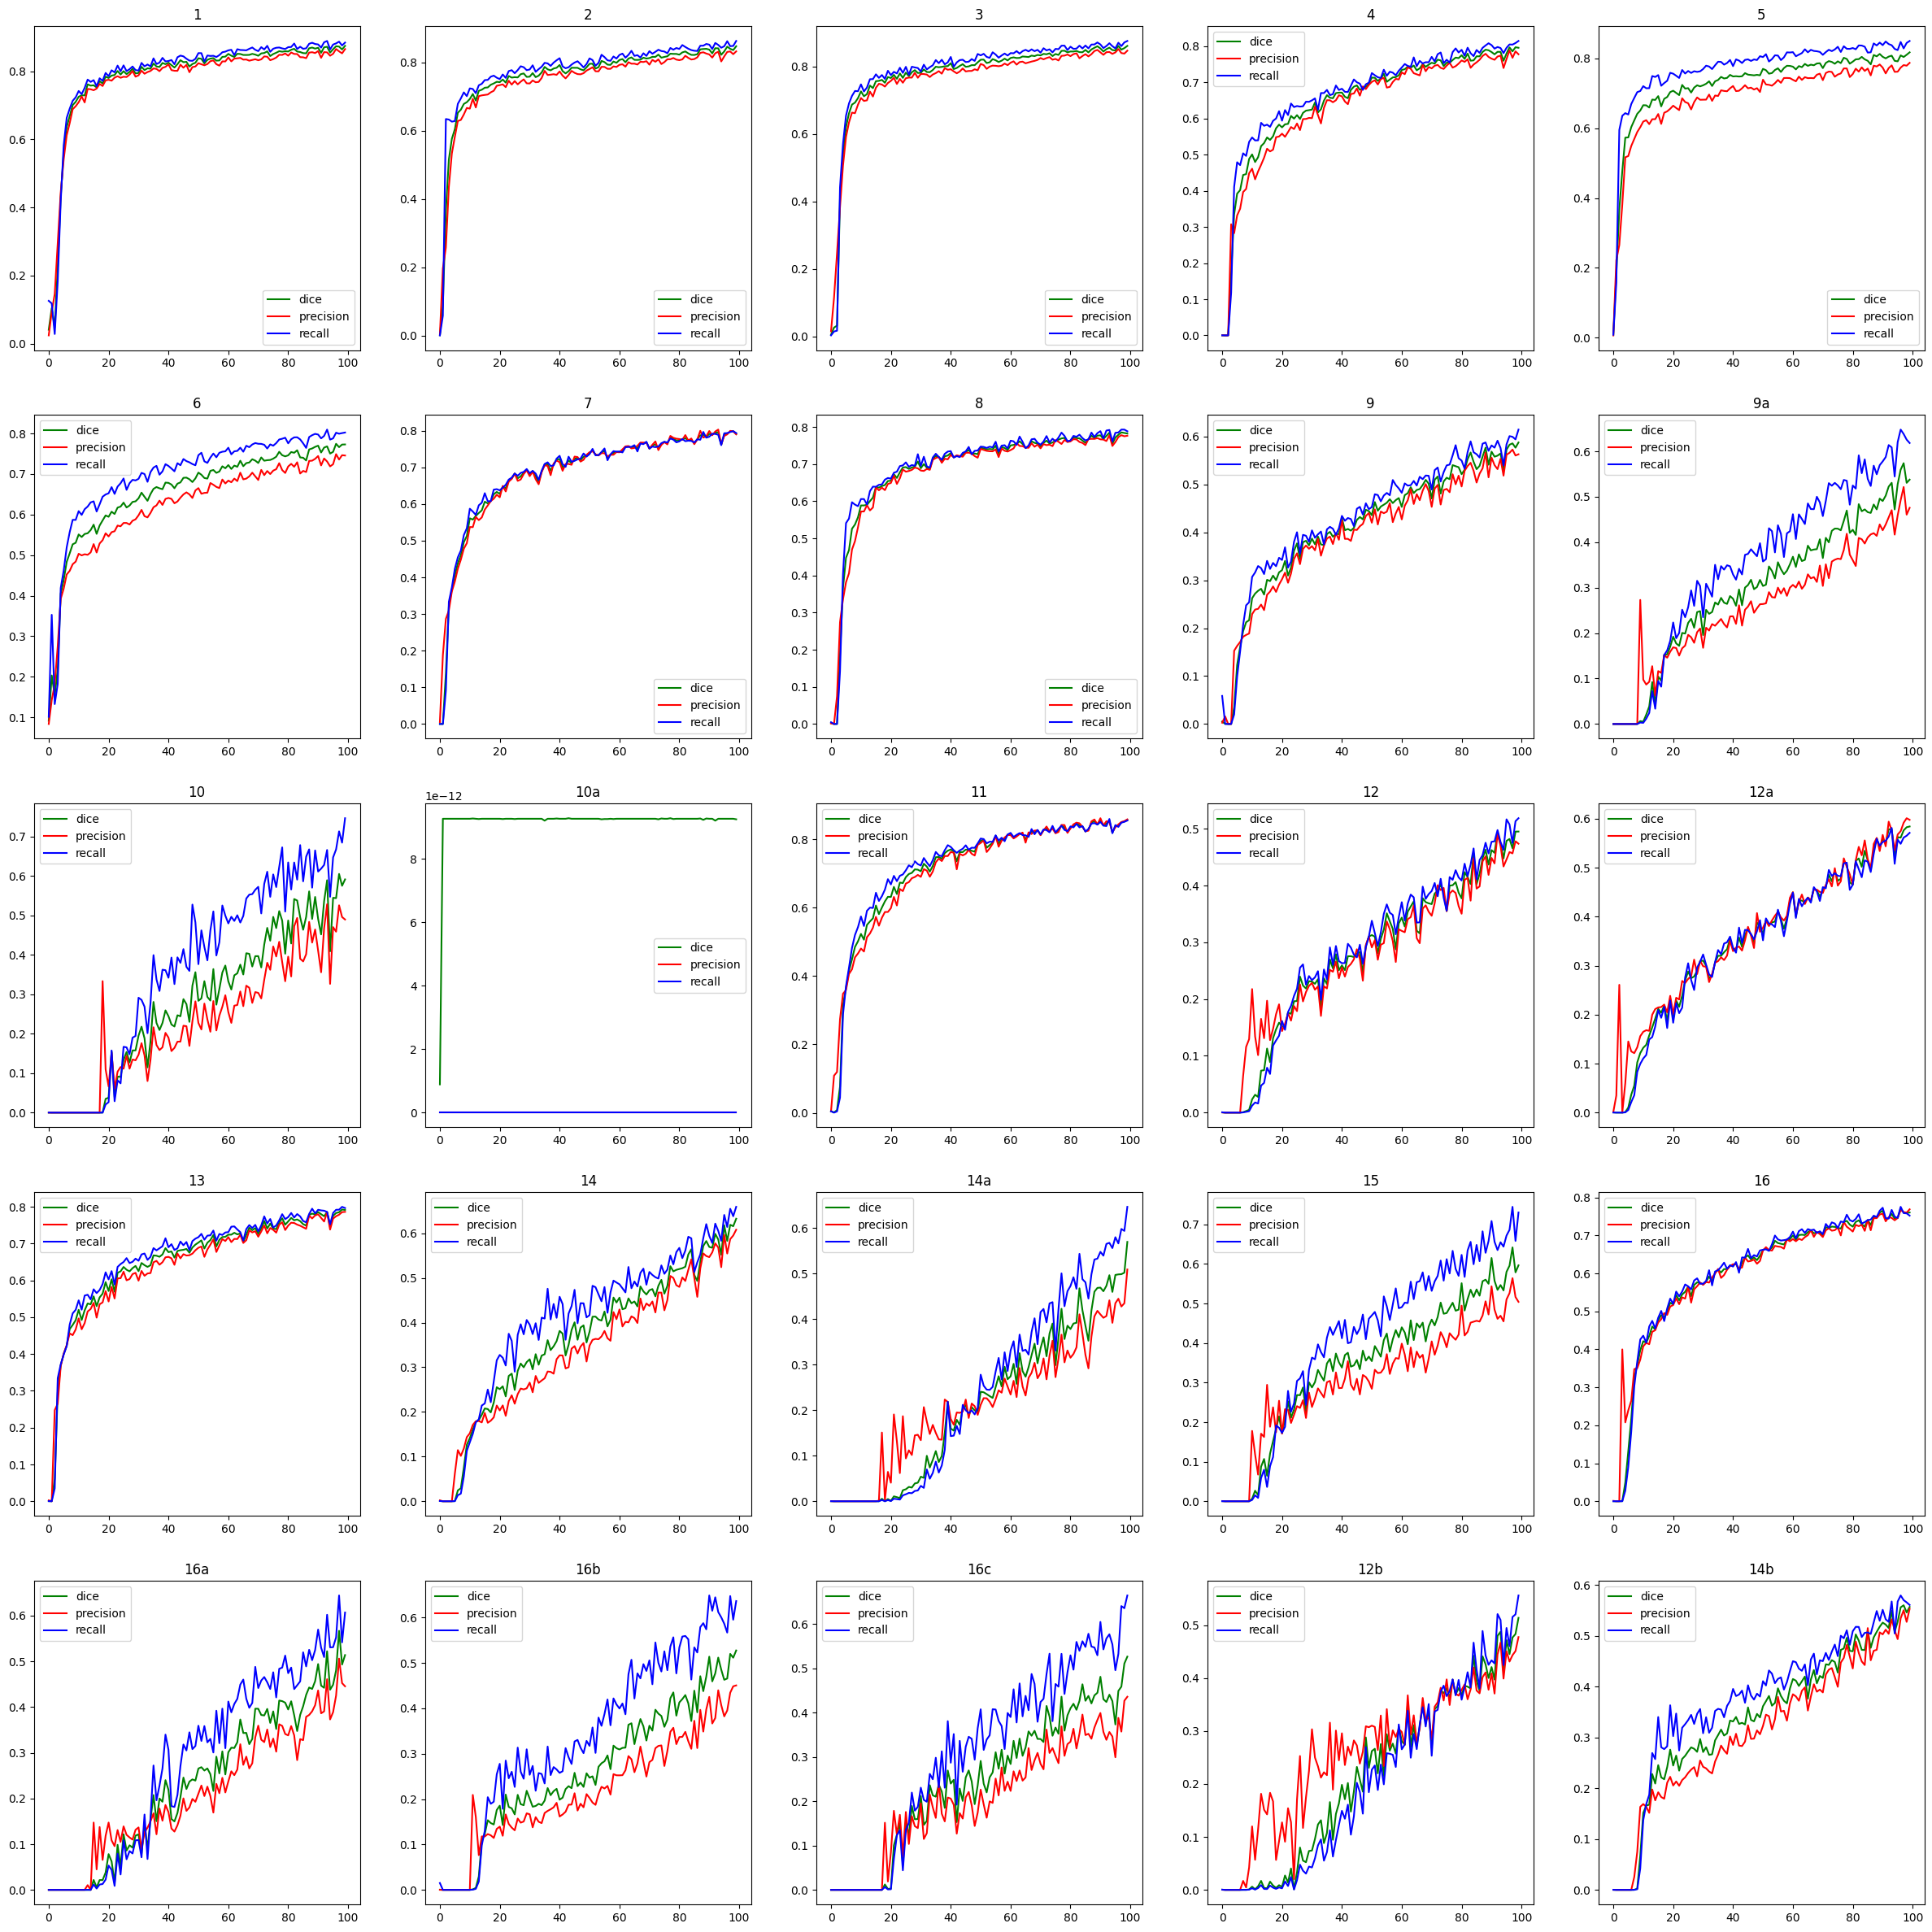

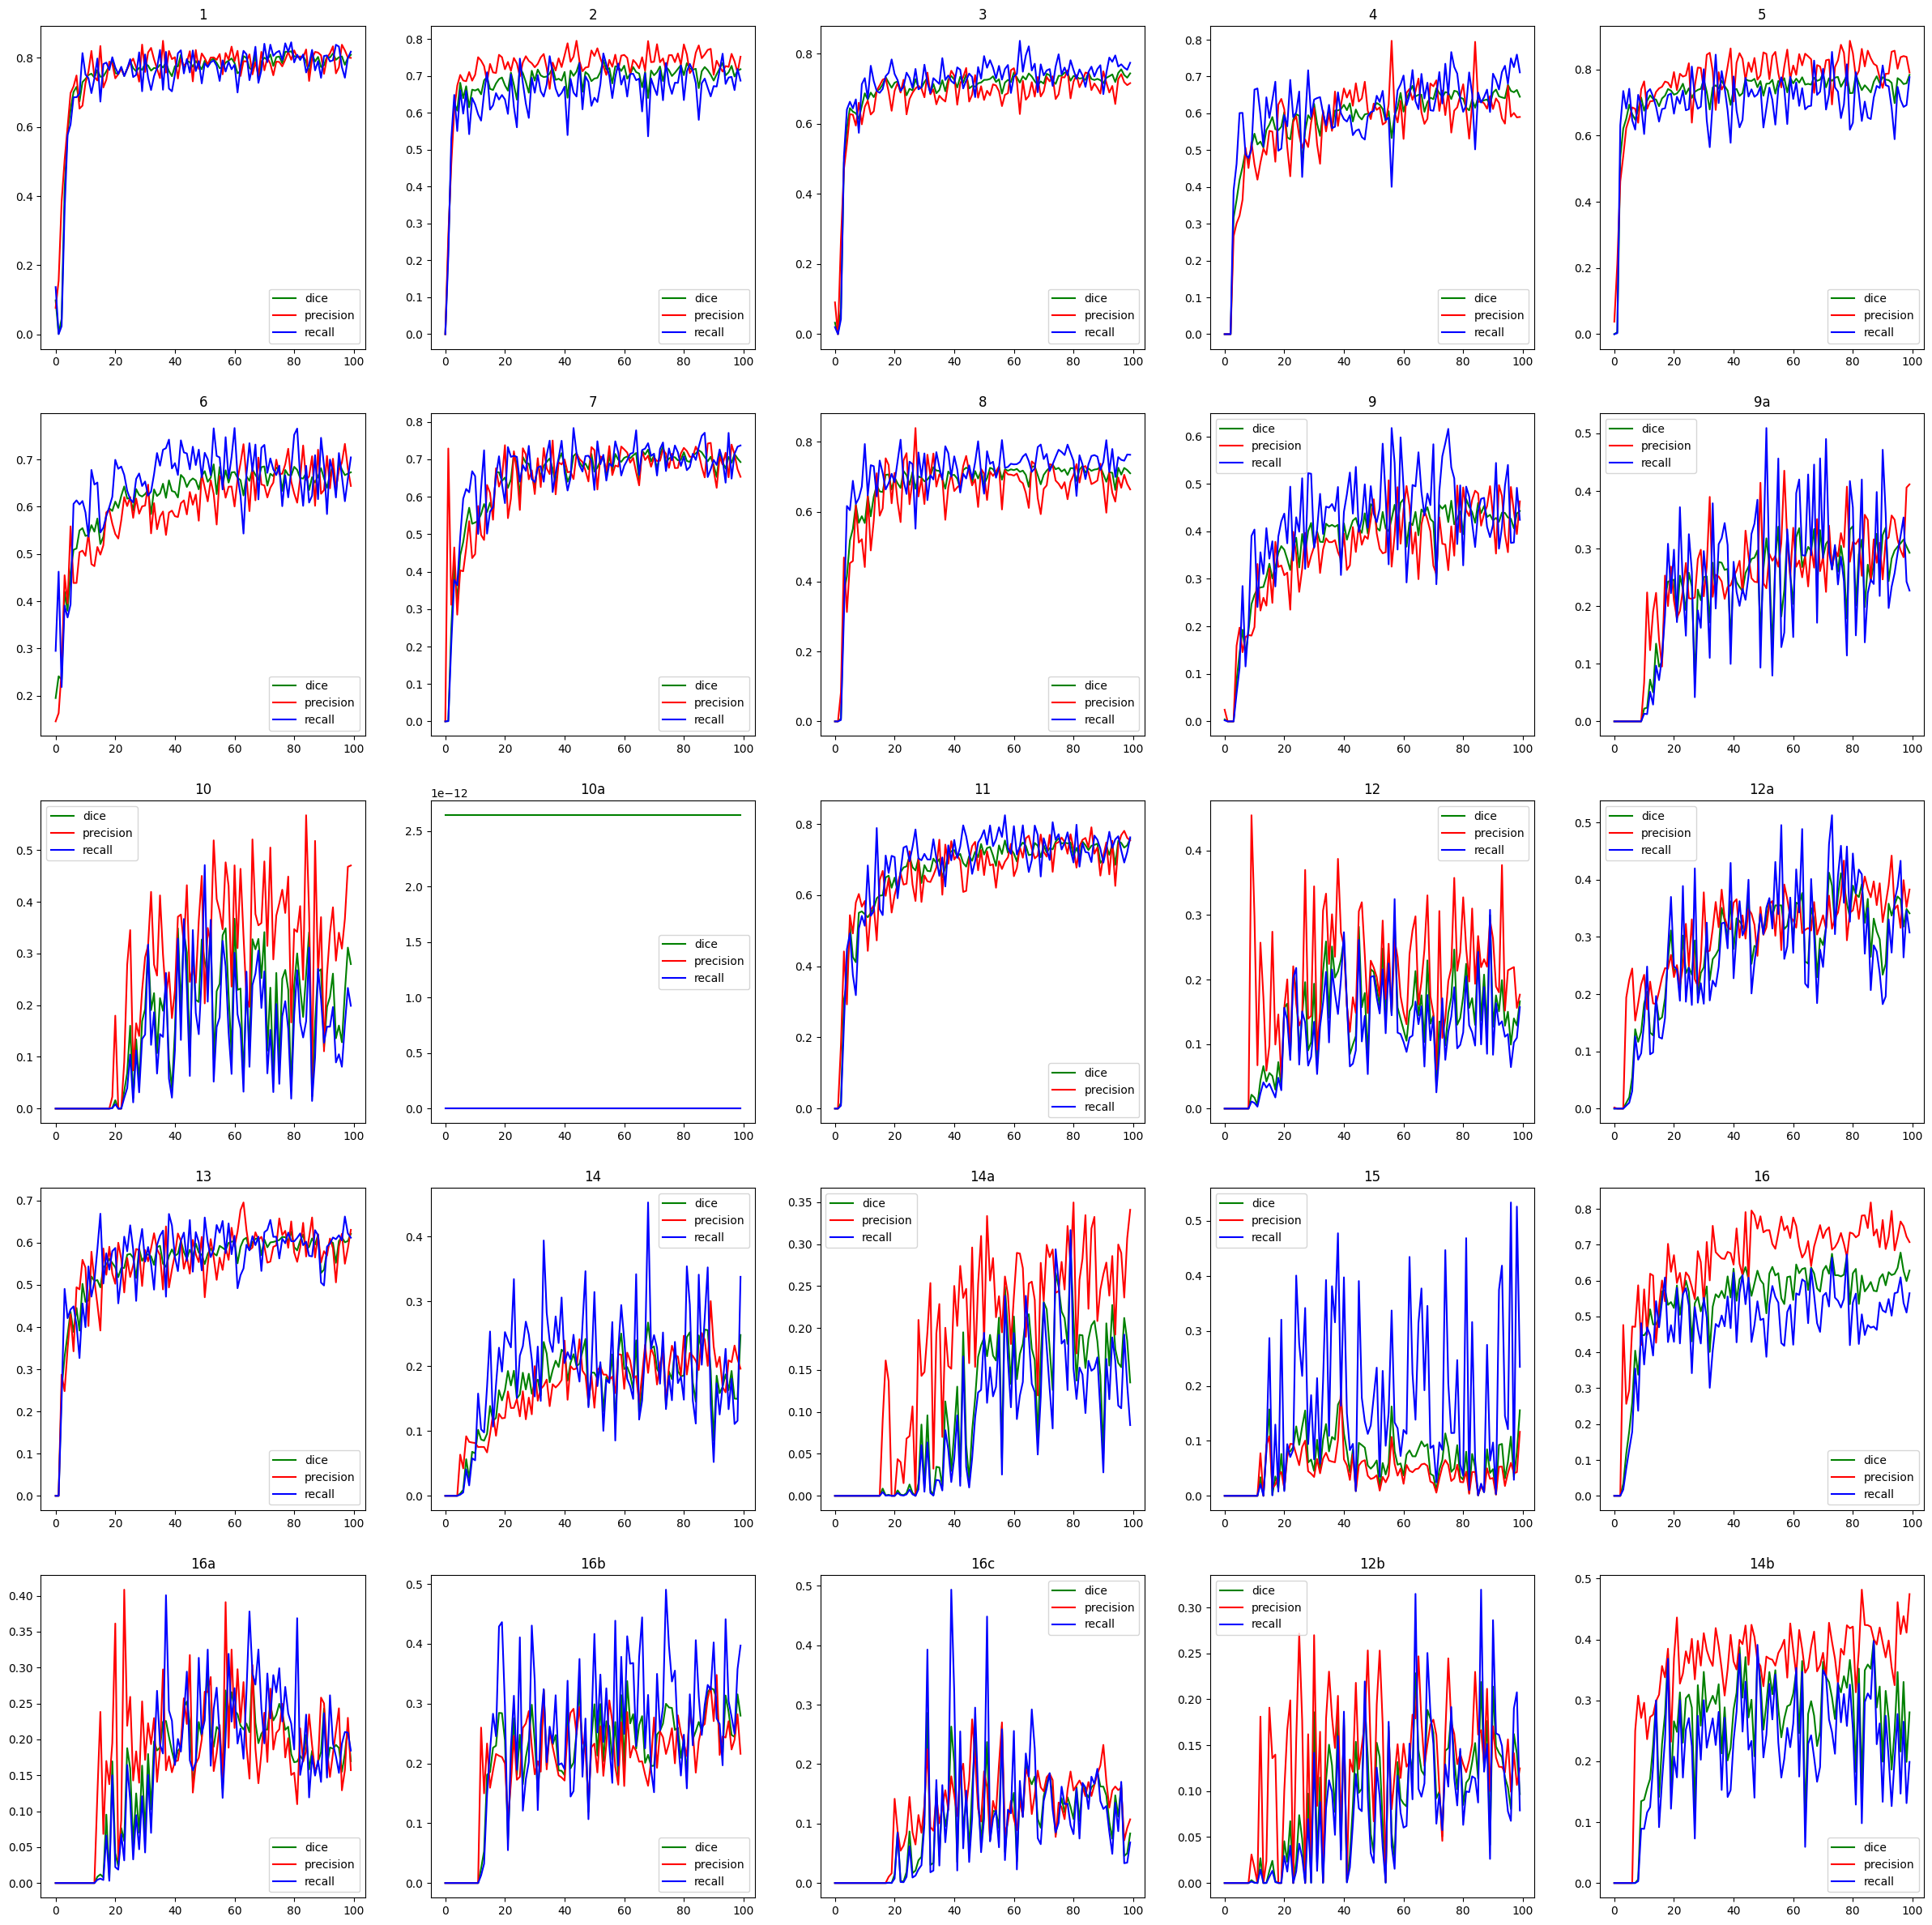

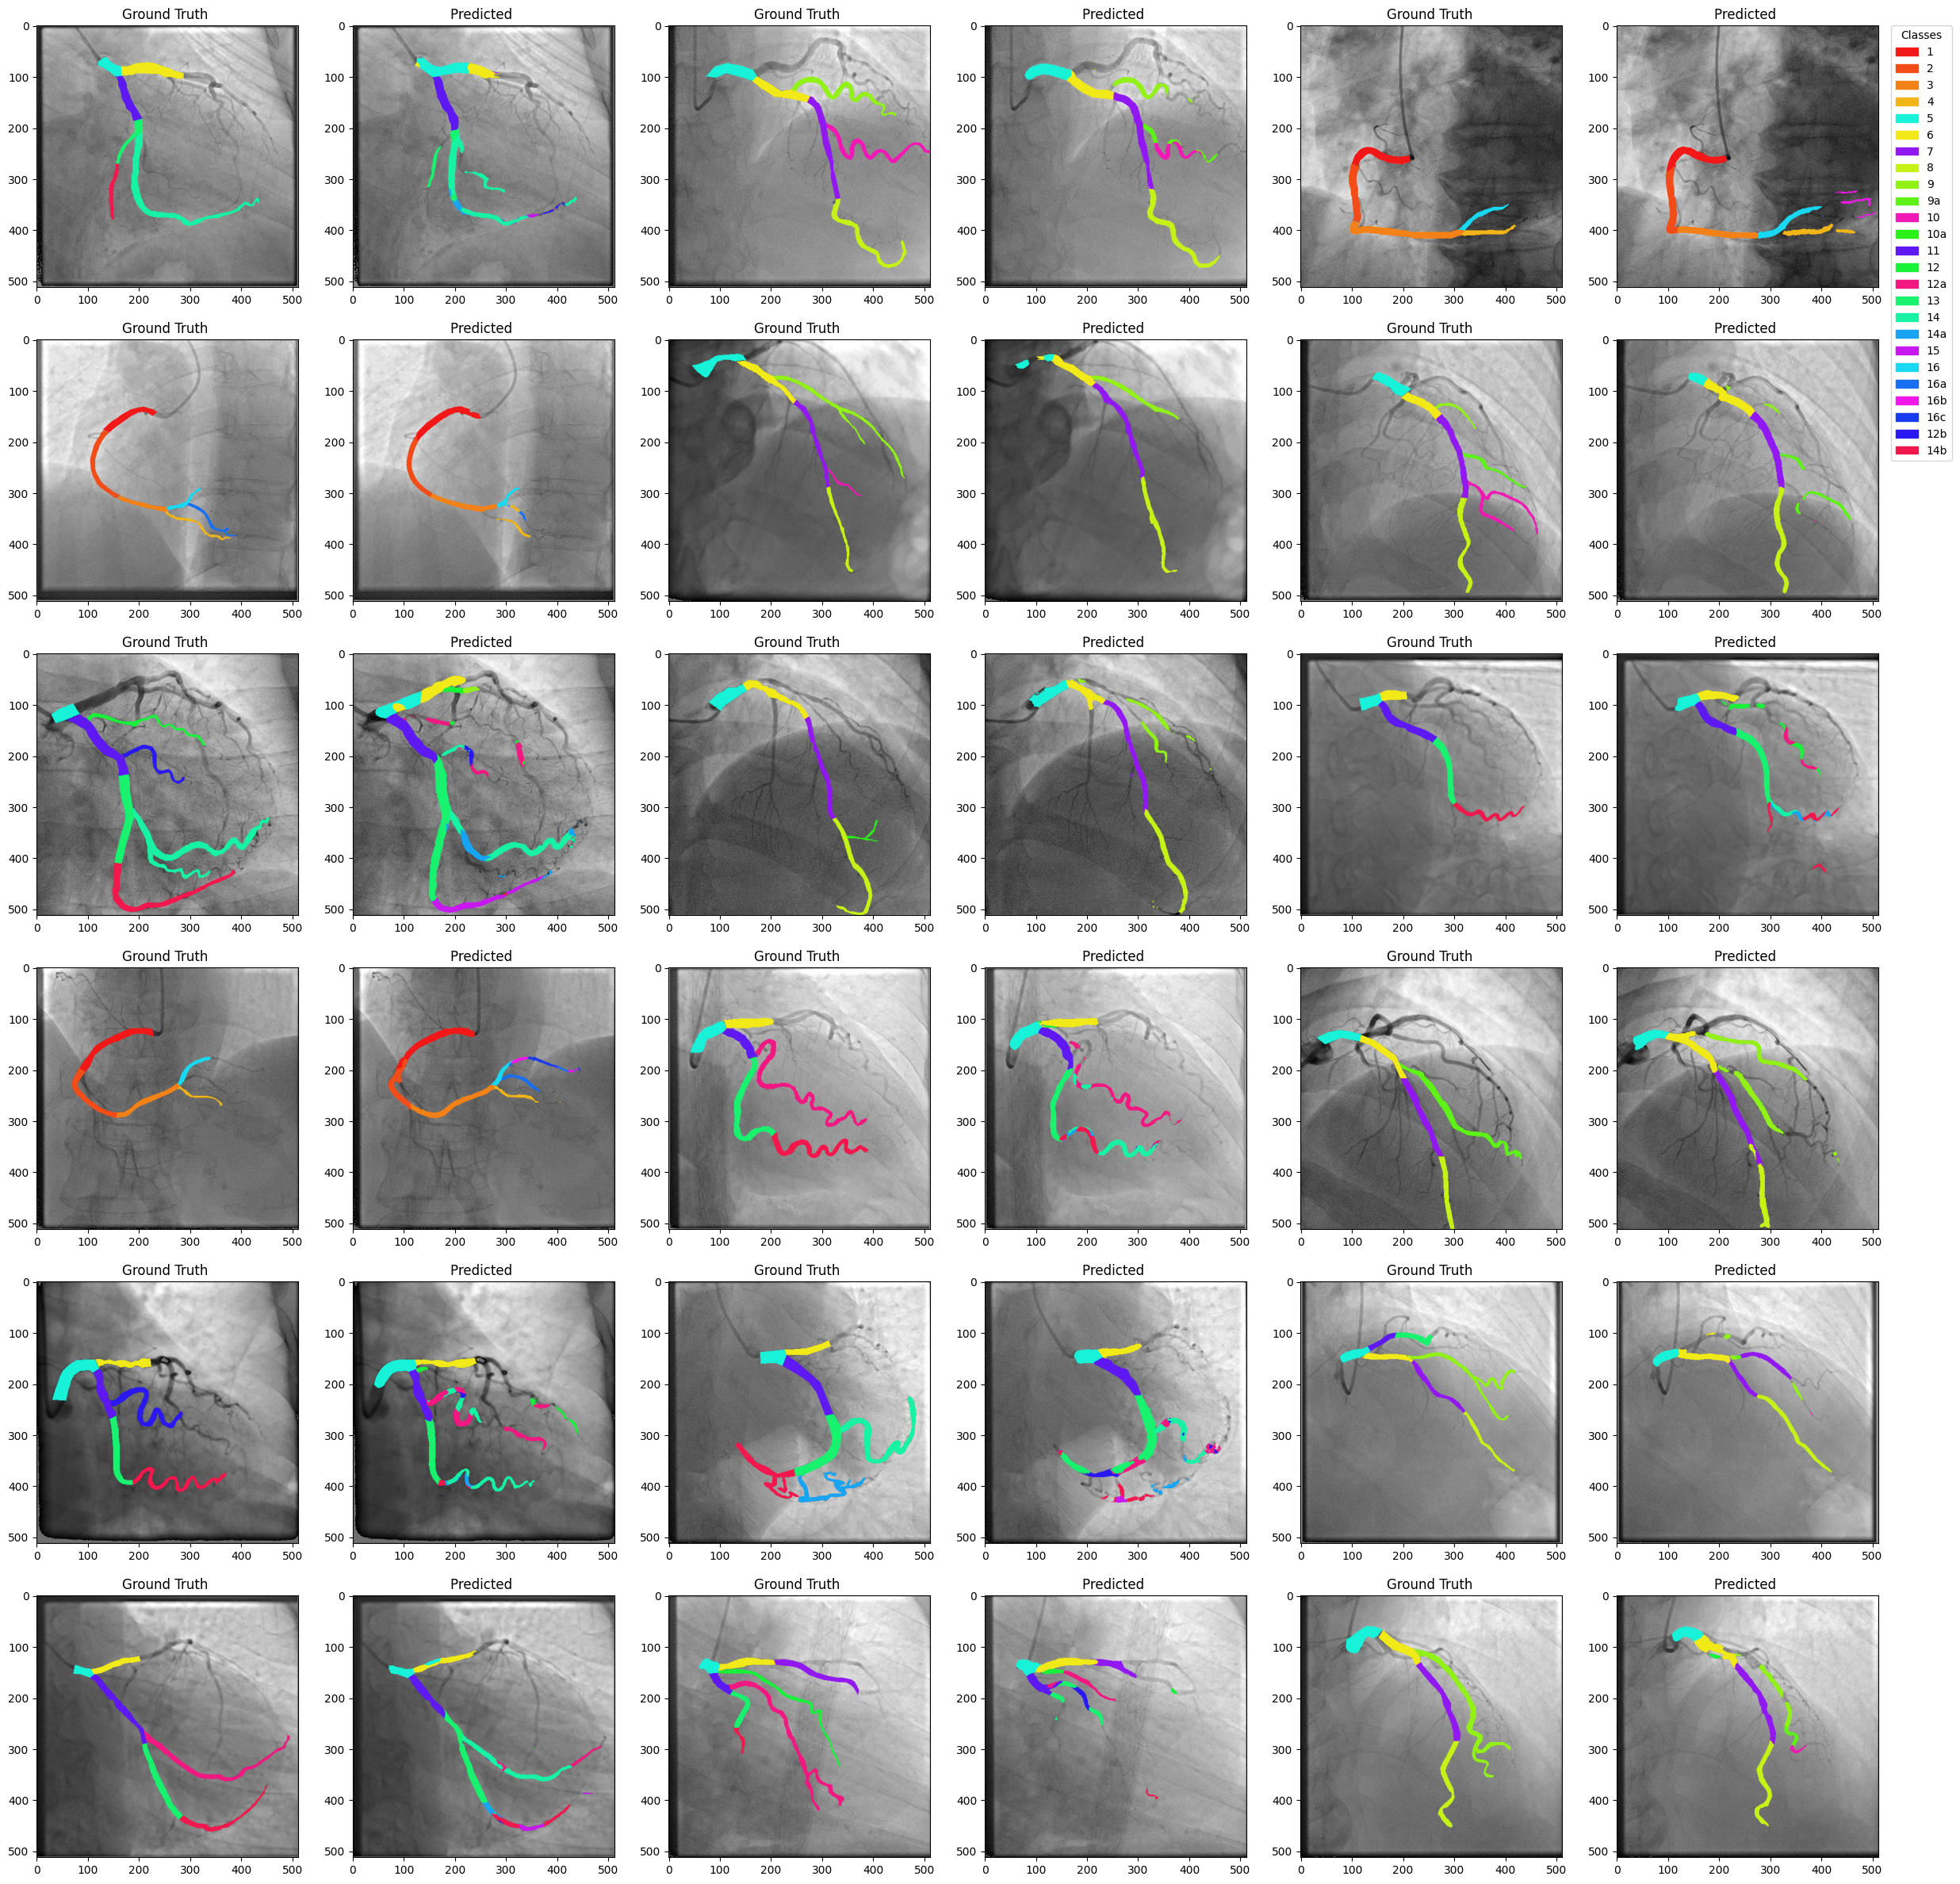

In [10]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)